In [1]:
# Visualization of activity difference between a classical neural network and a FGnet
# shows that FGNs are trainable over multiple layers
# shows that FGNs have less linear seperation of space

# this notebook showcases classic linear+tanh feedforward nets and full FGN nets

# you can try various: Network sizes, dropout probs, lambdas in the losses, different 2d data sets

In [2]:
from __future__ import print_function

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import scipy as sp
from scipy import stats
from sklearn import datasets as skdatasets

import sys
sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research/')
import Finite_Gaussian_Network_lib as fgnl
import Finite_Gaussian_Network_lib.fgn_helper_lib as fgnh

In [5]:
!gpustat

crescent  Thu Dec 26 18:35:48 2019
[0] GeForce GTX 1080 | 57'C,   0 % |  4662 /  8119 MB | salami(2905M) felix(1747M)
[1] GeForce GTX 1080 | 43'C,   0 % |    10 /  8119 MB |


In [6]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
print("Using device:", device)

# manualy set cuda device
torch.cuda.set_device(1)

CUDA Available:  True
Using device: cuda


In [7]:
# # random seeds
# torch.manual_seed(999)
# np.random.seed(999)

# torch.backends.cudnn.deterministic = True
# torch.cuda.manual_seed_all(999)

In [8]:
total_num_samples = 2048

# random moons
samples, labels = skdatasets.make_moons(n_samples=total_num_samples, noise=0.2, shuffle=True)

# random concentric circles
# samples, labels = skdatasets.make_circles(n_samples=total_num_samples, noise=0.08, factor=0.4, shuffle=True)

# train/test split
ratio=4.0/5.0
split_index = int(len(samples)*ratio)

train_samples, train_labels = samples[:split_index], labels[:split_index]
test_samples, test_labels = samples[split_index:], labels[split_index:]


# add noise?
X1 = np.arange(-10.0, 10.01, 0.5)
X1s, X2s = np.meshgrid(X1,X1)
noise_samples = np.reshape(zip(X1s.flatten(),X2s.flatten()),(-1,2))
noise_labels = np.array([np.random.choice([0,1]) for _ in range(len(noise_samples))])


# train_samples = np.concatenate((train_samples ,noise_samples),axis=0)
# train_labels = np.concatenate((train_labels ,noise_labels),axis=0)

# train_samples = noise_samples
# train_labels = noise_labels

num_samples = len(train_samples)

<IPython.core.display.Javascript object>


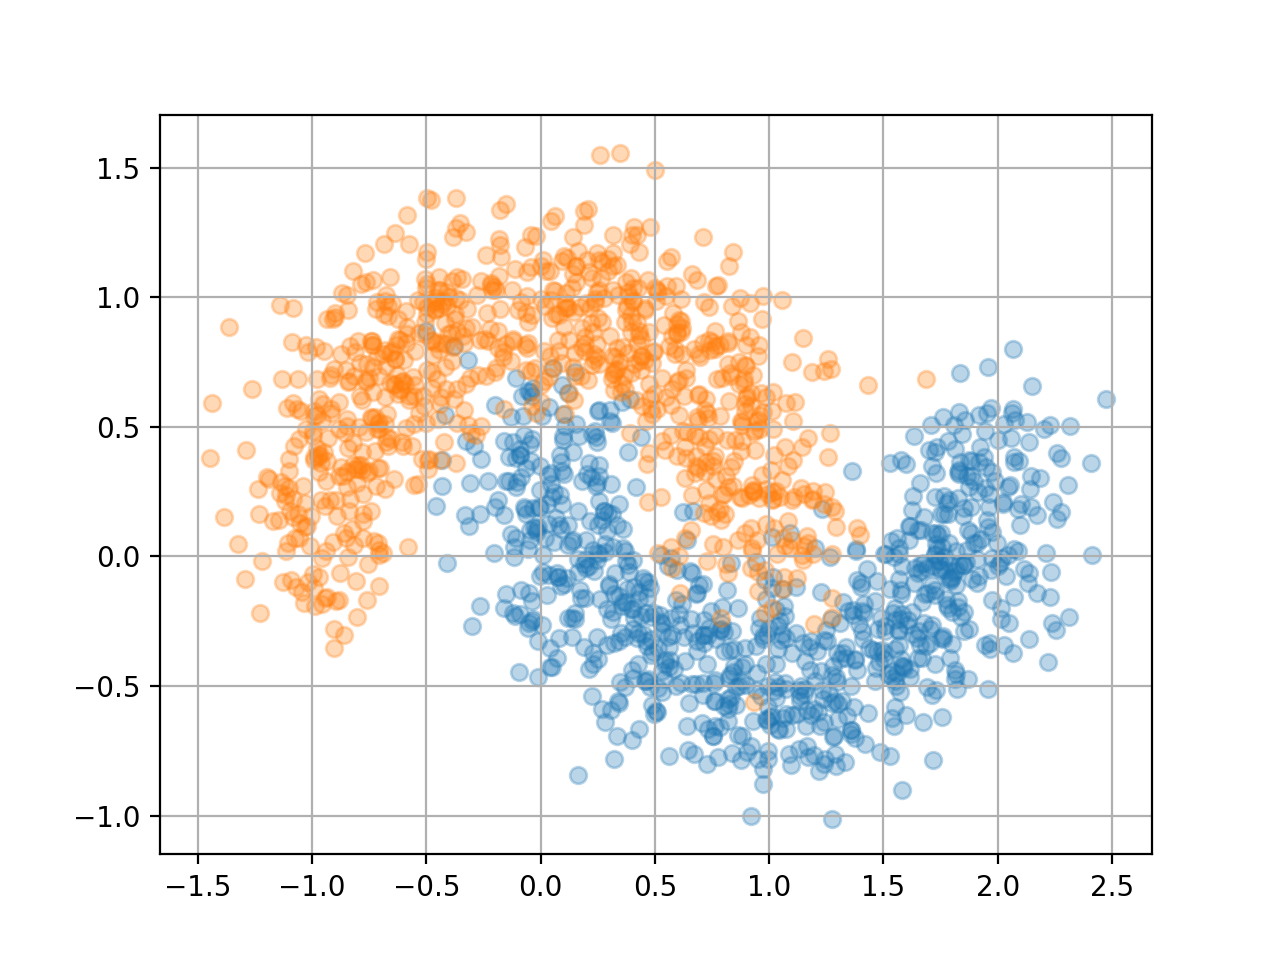

In [9]:
# 2D Check 
samples_x_1 = [x for x,l in zip(train_samples[:,0], train_labels) if l==0]
samples_y_1 = [y for y,l in zip(train_samples[:,1], train_labels) if l==0]

samples_x_2 = [x for x,l in zip(train_samples[:,0], train_labels) if l==1]
samples_y_2 = [y for y,l in zip(train_samples[:,1], train_labels) if l==1]

plt.scatter(samples_x_2, samples_y_2, alpha=0.3)
plt.scatter(samples_x_1, samples_y_1, alpha=0.3)

plt.grid(True)
plt.show()

In [10]:
# convert data to pytorch format 
tensor_train_x = torch.Tensor(train_samples)
tensor_train_y = torch.Tensor(train_labels)

tensor_test_x = torch.Tensor(test_samples)
tensor_test_y = torch.Tensor(test_labels)

my_dataset = torch.utils.data.TensorDataset(tensor_train_x, tensor_train_y) # create your dataset
my_test_data = torch.utils.data.TensorDataset(tensor_test_x,tensor_test_y) # create your dataset

my_dataloader = torch.utils.data.DataLoader(my_dataset, batch_size=32, shuffle=True) # create your dataloader
my_test_dataloader = torch.utils.data.DataLoader(my_test_data, batch_size=32, shuffle=True) # create your dataloader

In [11]:
### PART 1: classic feedforward net (linear with bias + tanh)

In [12]:
# loss functions for the classic net
lmbda_l2 = (4.0*0.1/len(my_dataloader.dataset))
print(lmbda_l2)
      
classical_cross_ent_loss = fgnh.def_classical_cross_ent_loss(lmbda_l2)

0.0002442002442


In [13]:
# Initialize the classic network
hidden_layer_sizes = [32,32,32]
drop_p = 0.

In [14]:
classic_model = fgnl.Feedforward_Classic_net(in_feats=2, out_feats=2, hidden_layer_sizes=hidden_layer_sizes, drop_p=drop_p).to(device)

In [15]:
# define model params to optimize
classic_optimizer = optim.Adam(filter(lambda p: p.requires_grad, classic_model.parameters()))
# classic_optimizer = optim.RMSprop(filter(lambda p: p.requires_grad, classic_model.parameters()))

In [16]:
epochs = 20

In [17]:
# train the network for N epochs
print("# epochs:", epochs)
classic_train_res = fgnh.train(classic_model, my_dataloader, 
                             classical_cross_ent_loss, classic_optimizer, epochs, save_hist=2, verbose=True, 
                             pred_func=fgnh.cross_ent_pred_accuracy, test_loader=my_test_dataloader)

# epochs: 20
Epoch 0 Train set - Average loss: 0.4543, Accuracy: 1291/1638 (79%)
Test set - Average loss: 0.3486, Accuracy: 352/410 (86%)
Epoch 1 Train set - Average loss: 0.3224, Accuracy: 1419/1638 (87%)
Test set - Average loss: 0.2755, Accuracy: 358/410 (87%)
Epoch 2 Train set - Average loss: 0.3008, Accuracy: 1434/1638 (88%)
Test set - Average loss: 0.2203, Accuracy: 384/410 (94%)
Epoch 3 Train set - Average loss: 0.2342, Accuracy: 1509/1638 (92%)
Test set - Average loss: 0.1641, Accuracy: 388/410 (95%)
Epoch 4 Train set - Average loss: 0.2151, Accuracy: 1504/1638 (92%)
Test set - Average loss: 0.1347, Accuracy: 387/410 (94%)
Epoch 5 Train set - Average loss: 0.2031, Accuracy: 1508/1638 (92%)
Test set - Average loss: 0.1117, Accuracy: 399/410 (97%)
Epoch 6 Train set - Average loss: 0.1852, Accuracy: 1522/1638 (93%)
Test set - Average loss: 0.1225, Accuracy: 391/410 (95%)
Epoch 7 Train set - Average loss: 0.1823, Accuracy: 1523/1638 (93%)
Test set - Average loss: 0.1403, Accuracy: 3

In [18]:
# test the statibility of the model (these numbers should be same as final lines above)
_ = fgnh.test(classic_model, my_dataloader,
                        classical_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

_ = fgnh.test(classic_model, my_test_dataloader,
                        classical_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Test set - Average loss: 0.1139, Accuracy: 1577/1638 (96%)
Test set - Average loss: 0.0990, Accuracy: 394/410 (96%)


<IPython.core.display.Javascript object>


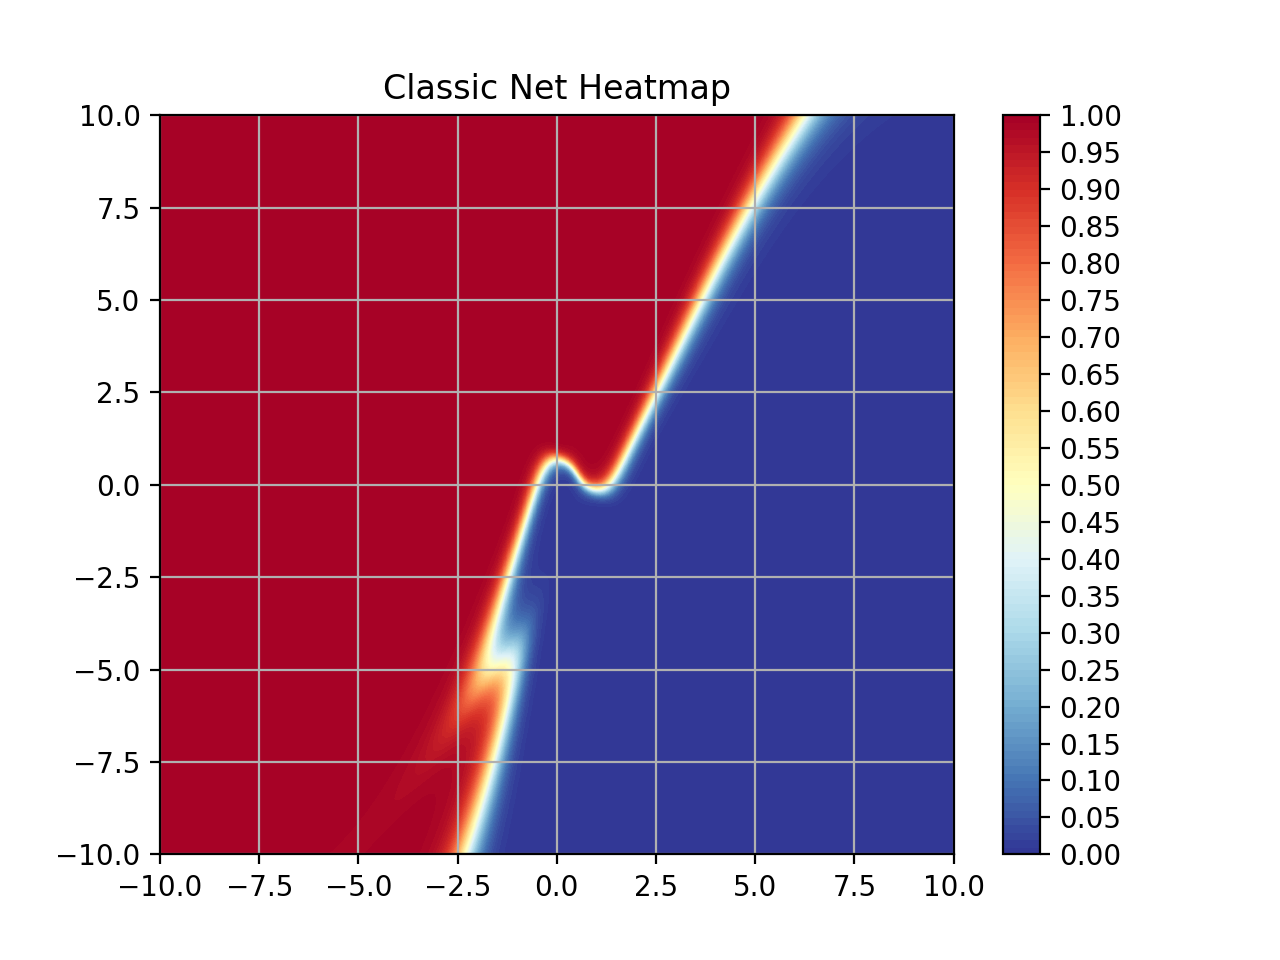

<IPython.core.display.Javascript object>


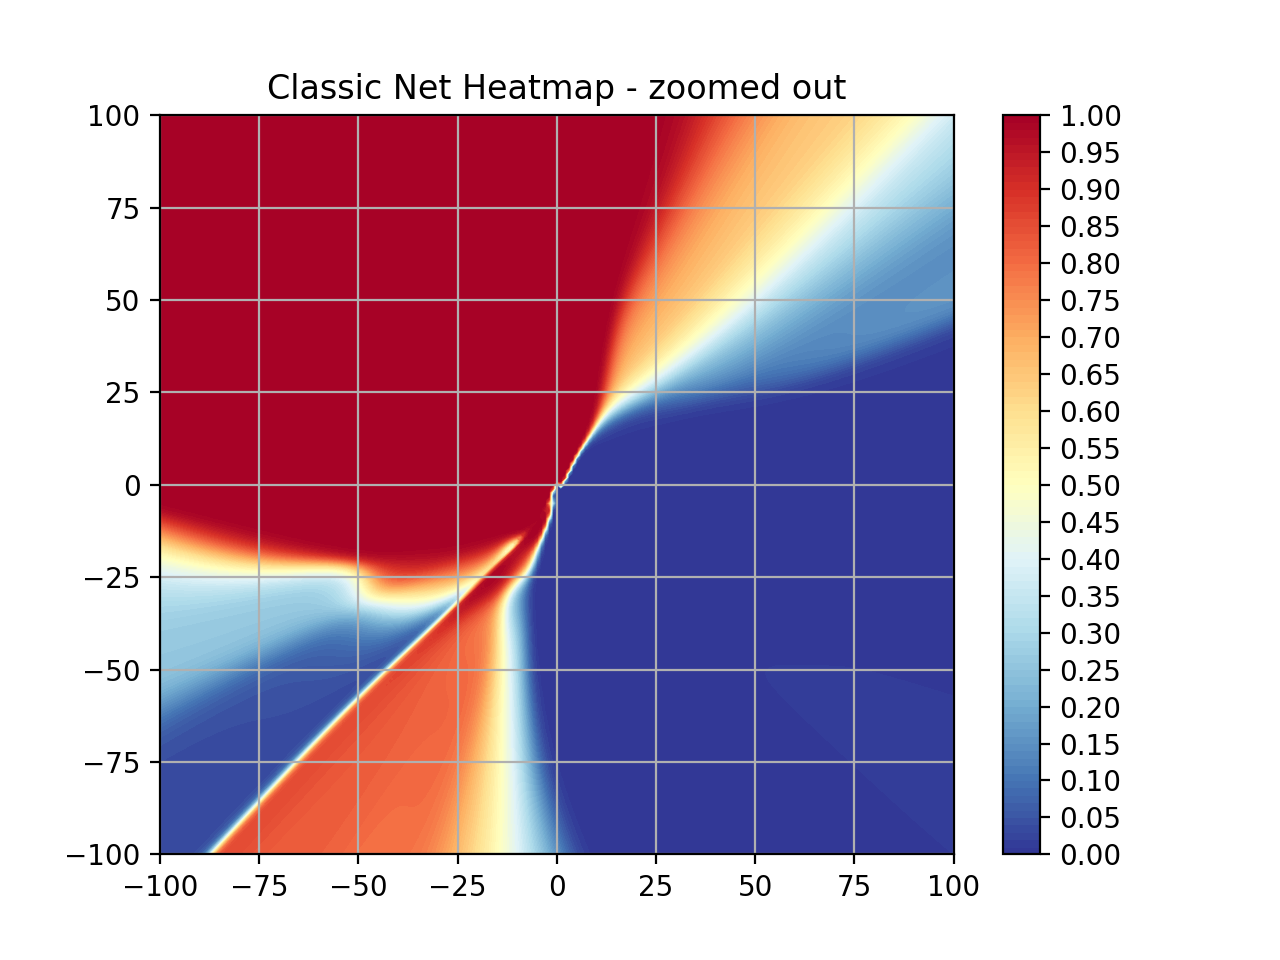

In [19]:
fgnh.plot_2D_heatmap(classic_model, title="Classic Net Heatmap")
fgnh.plot_2D_heatmap(classic_model, title="Classic Net Heatmap - zoomed out", scale=100.0)

In [20]:
### PART 2: fully FGN network

In [21]:
### Loss Functions for the FGN

# importances of the constraints
lmbda_l2 = (4.0*0.1/len(my_dataloader.dataset))
lmbda_sigs = 100.0*lmbda_l2
# sig_params = sum(p.numel() for n,p in fgn_model.named_parameters() if 'sigs' in n)
# lmbda_sigs = (1.0/sig_params)

# lmbda_l2 = 0.0
# lmbda_sigs = 0.0
print("lambda for l2 loss", lmbda_l2)
print("lambda for sigs^2 loss", lmbda_sigs)


fgn_cross_ent_loss = fgnl.def_fgn_cross_ent_loss(lmbda_l2, lmbda_sigs)


lambda for l2 loss 0.0002442002442
lambda for sigs^2 loss 0.02442002442


In [22]:
# fgn specific params
print("hidden layers:", hidden_layer_sizes)
# covariance type: sphere, diag or full
covar_type = 'diag'
print("covariance:", covar_type)
ordinal = float(3)
print("ordinal for norm:", ordinal)
# non_lin = False
non_lin = True
print("non linearity:", non_lin)
free_biases=True
print("free biases:", free_biases)

print("drop prob:", drop_p)



# Initialize the fgn network
fgn_model = fgnl.Feedforward_FGN_net(in_feats=2, out_feats=2, hidden_layer_sizes=hidden_layer_sizes, drop_p=drop_p,
                                     covar_type=covar_type, ordinal=ordinal, non_lin=non_lin, free_biases=free_biases).to(device)

hidden layers: [32, 32, 32]
covariance: diag
ordinal for norm: 3.0
non linearity: True
free biases: True
drop prob: 0.0


In [23]:
# define model params to optimize
fgn_optimizer = optim.Adam(filter(lambda p: p.requires_grad, fgn_model.parameters()))
# fgn_optimizer = optim.RMSprop(filter(lambda p: p.requires_grad, fgn_model.parameters()))

<IPython.core.display.Javascript object>


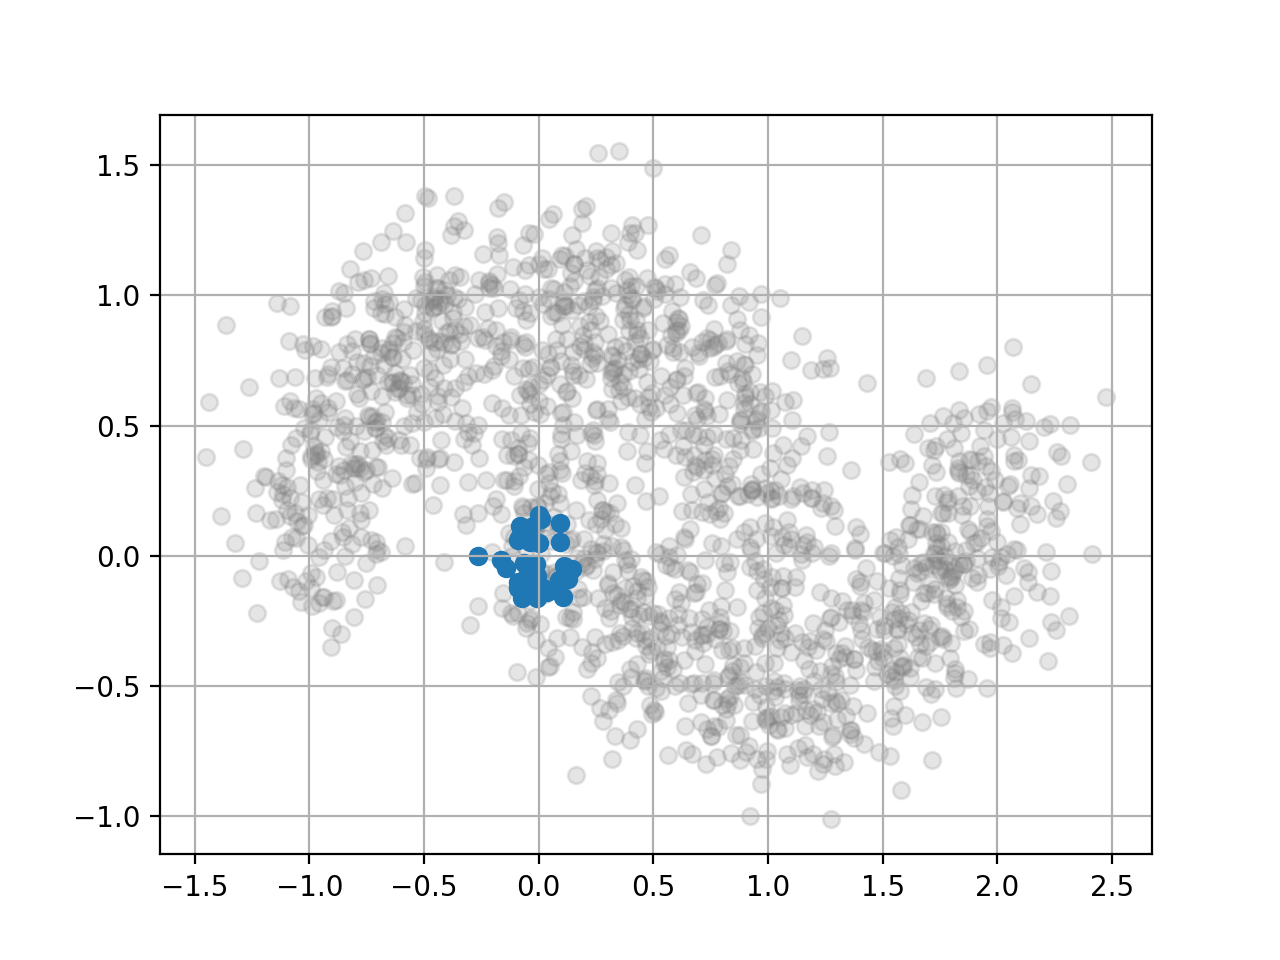

In [24]:
# plot centers of first layer
x = zip(*fgn_model.state_dict()['hidden_layers.0.centers'].detach().cpu().numpy())
plt.scatter(np.concatenate((samples_x_1,samples_x_2)), np.concatenate((samples_y_1,samples_y_2)), alpha=0.2, c='gray')
plt.scatter(x[0], x[1])
# plt.axis([-8,10, -8,10])
plt.grid(True)
plt.show()

In [25]:
# set centers of first layer
fgn_model.set_first_layer_centers(my_dataloader)

<IPython.core.display.Javascript object>


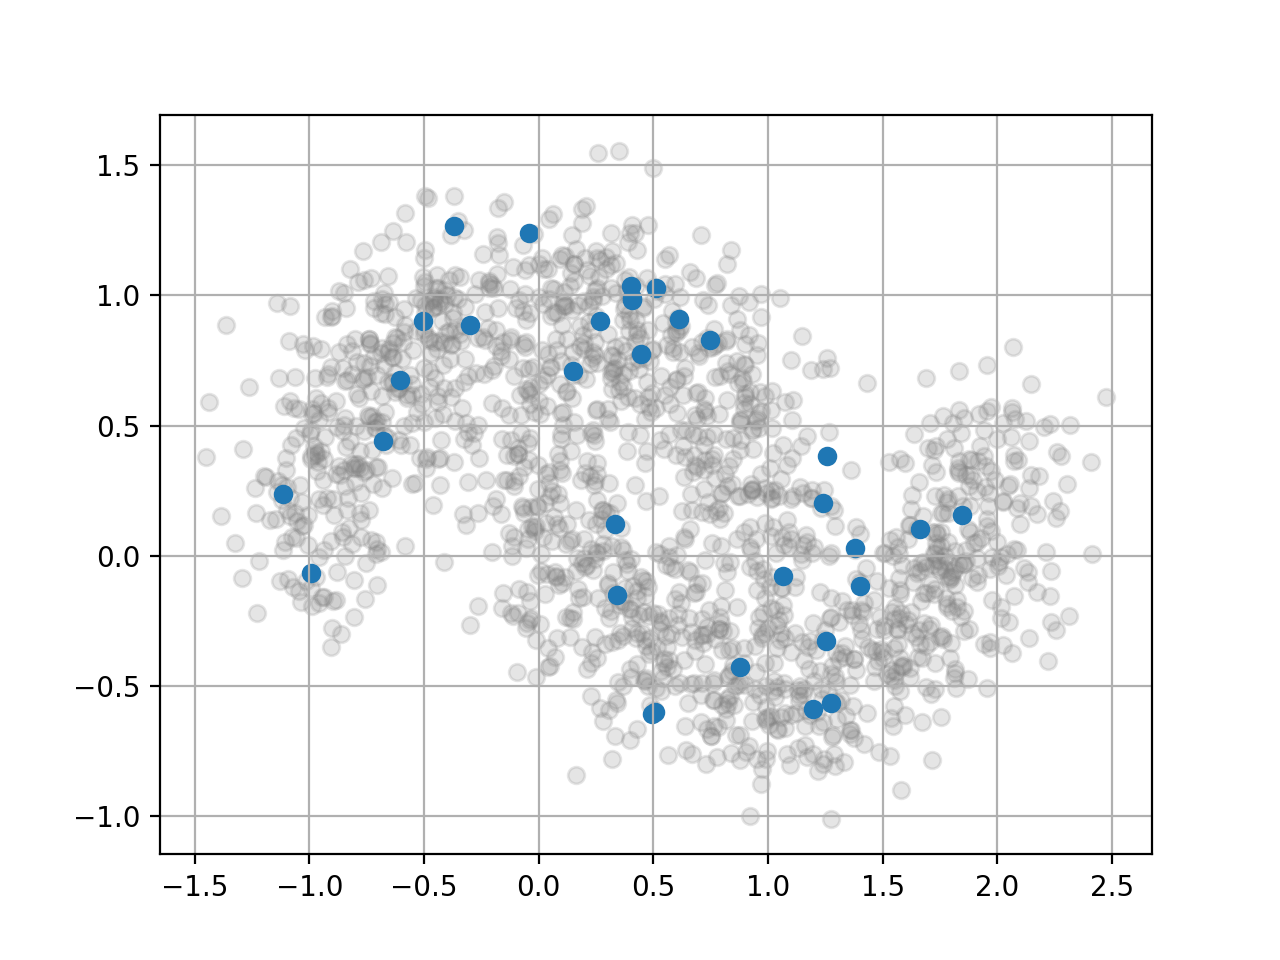

In [26]:
# visualize them
# plot centers of first layer
x = zip(*fgn_model.state_dict()['hidden_layers.0.centers'].detach().cpu().numpy())
plt.scatter(np.concatenate((samples_x_1,samples_x_2)), np.concatenate((samples_y_1,samples_y_2)), alpha=0.2, c='gray')
plt.scatter(x[0], x[1])
# plt.axis([-8,10, -8,10])
plt.grid(True)
plt.show()

In [27]:
# train the network for N epochs
fgn_train_res = fgnh.train(fgn_model, my_dataloader, 
                             fgn_cross_ent_loss, fgn_optimizer, epochs, save_hist=2, verbose=True, 
                             pred_func=fgnh.cross_ent_pred_accuracy, test_loader=my_test_dataloader)

Epoch 0 Train set - Average loss: 10.8303, Accuracy: 1405/1638 (86%)
Test set - Average loss: 5.7340, Accuracy: 387/410 (94%)
Epoch 1 Train set - Average loss: 4.6469, Accuracy: 1529/1638 (93%)
Test set - Average loss: 3.7668, Accuracy: 394/410 (96%)
Epoch 2 Train set - Average loss: 3.3778, Accuracy: 1524/1638 (93%)
Test set - Average loss: 2.9119, Accuracy: 395/410 (96%)
Epoch 3 Train set - Average loss: 2.7307, Accuracy: 1531/1638 (93%)
Test set - Average loss: 2.4453, Accuracy: 388/410 (95%)
Epoch 4 Train set - Average loss: 2.3182, Accuracy: 1527/1638 (93%)
Test set - Average loss: 2.0914, Accuracy: 394/410 (96%)
Epoch 5 Train set - Average loss: 2.0658, Accuracy: 1510/1638 (92%)
Test set - Average loss: 1.8444, Accuracy: 392/410 (96%)
Epoch 6 Train set - Average loss: 1.8075, Accuracy: 1544/1638 (94%)
Test set - Average loss: 1.6674, Accuracy: 393/410 (96%)
Epoch 7 Train set - Average loss: 1.6500, Accuracy: 1529/1638 (93%)
Test set - Average loss: 1.5004, Accuracy: 398/410 (97%)

In [28]:
# test the statibility of the model (these numbers should be close as final lines above, depending)

print("Random Eval OFF")
fgn_model.set_random_eval(False)
_ = fgnh.test(fgn_model, my_dataloader,
                        fgn_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

_ = fgnh.test(fgn_model, my_test_dataloader,
                        fgn_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

print("Random Eval ON")
fgn_model.set_random_eval(True)
_ = fgnh.test(fgn_model, my_dataloader,
                        fgn_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

_ = fgnh.test(fgn_model, my_test_dataloader,
                        fgn_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Random Eval OFF
Test set - Average loss: 0.8198, Accuracy: 1560/1638 (95%)
Test set - Average loss: 0.7982, Accuracy: 393/410 (96%)
Random Eval ON
Test set - Average loss: 0.8198, Accuracy: 1560/1638 (95%)
Test set - Average loss: 0.7982, Accuracy: 393/410 (96%)


<IPython.core.display.Javascript object>


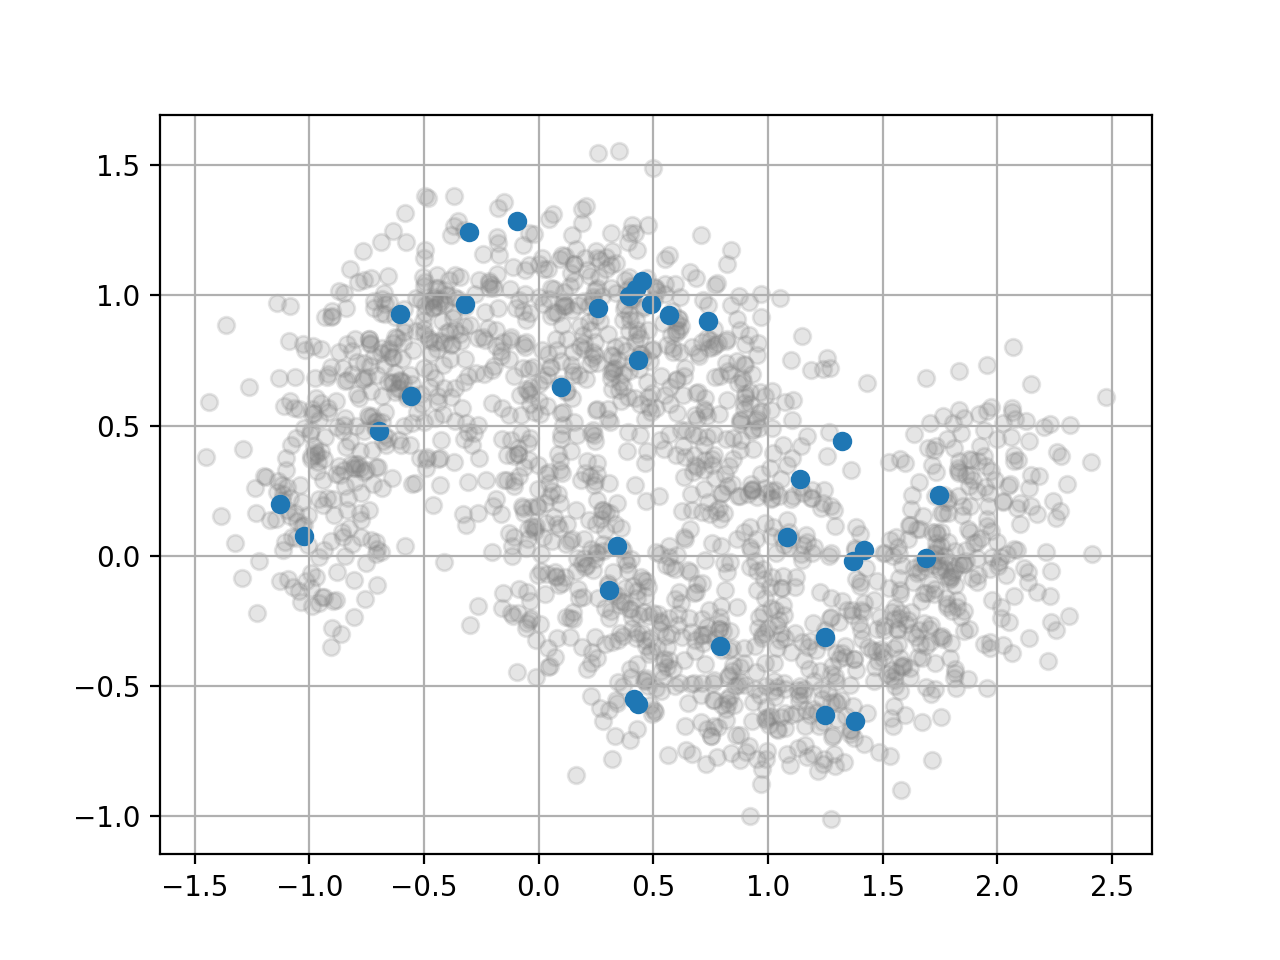

In [29]:
# plot centers of first layer
x = zip(*fgn_model.state_dict()['hidden_layers.0.centers'].detach().cpu().numpy())
plt.scatter(np.concatenate((samples_x_1,samples_x_2)), np.concatenate((samples_y_1,samples_y_2)), alpha=0.2, c='gray')
plt.scatter(x[0], x[1])
# plt.axis([-8,10, -8,10])
plt.grid(True)
plt.show()

<IPython.core.display.Javascript object>


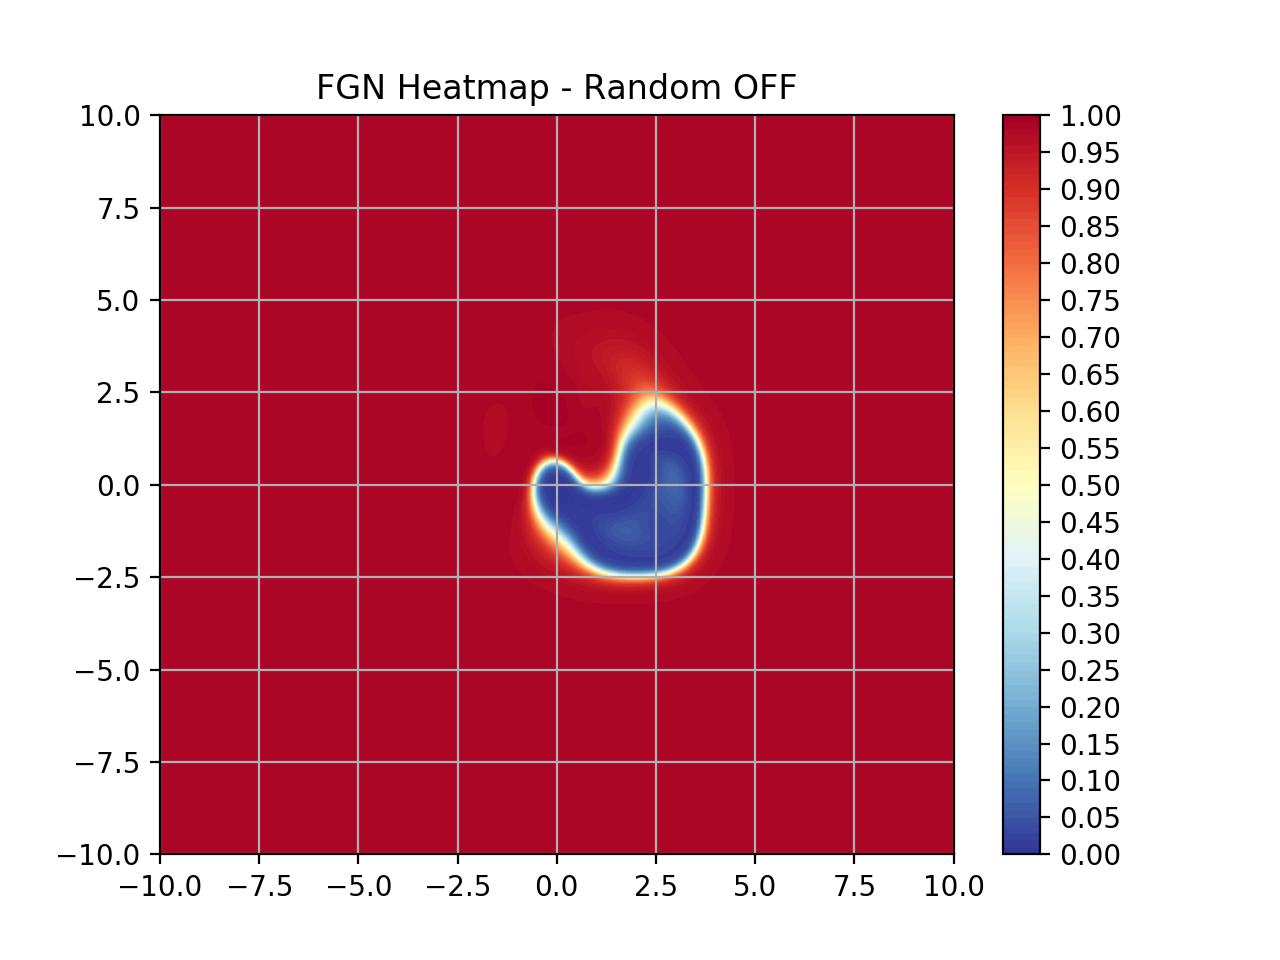

<IPython.core.display.Javascript object>


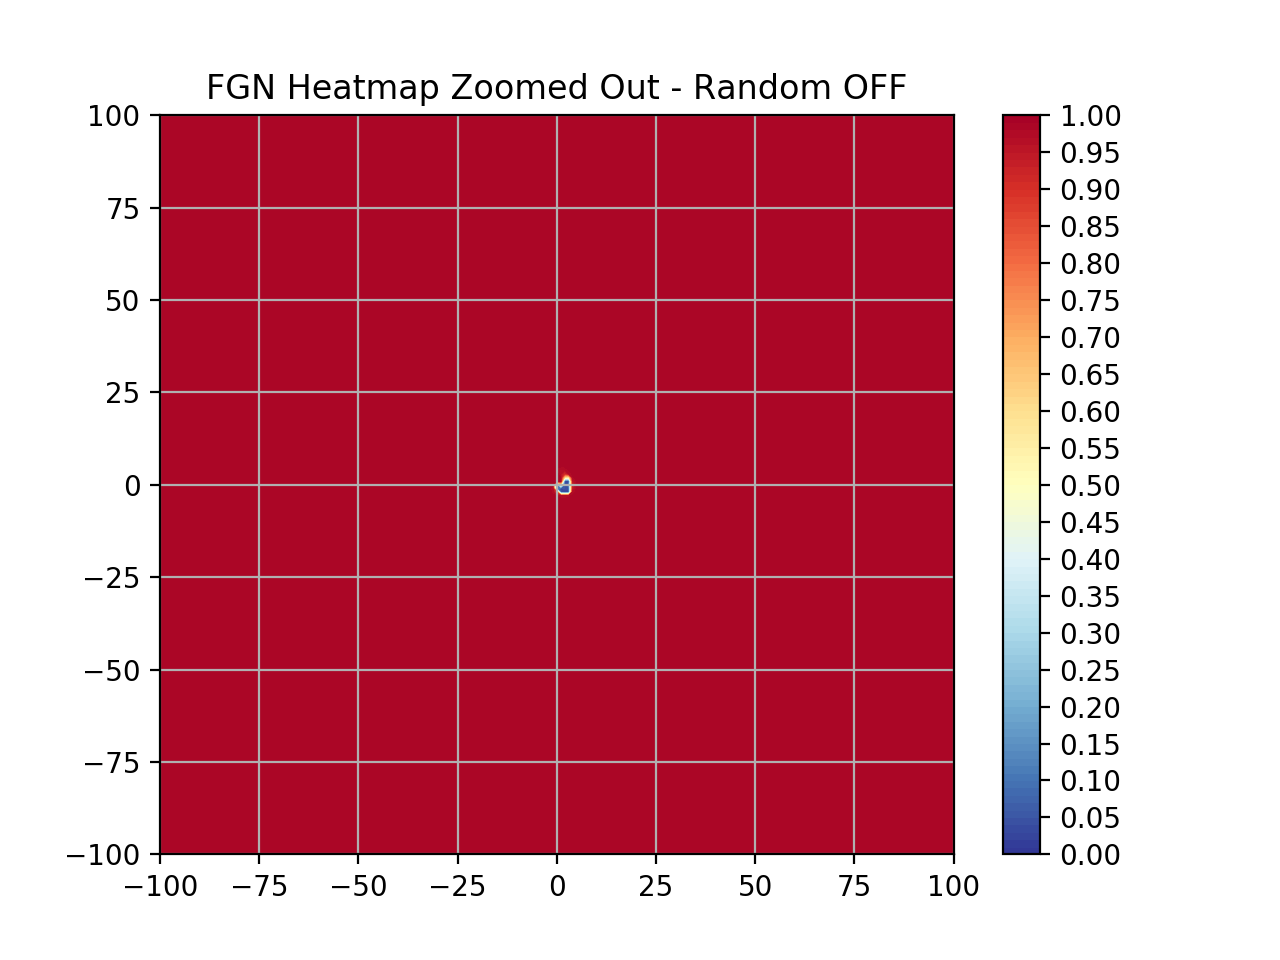

<IPython.core.display.Javascript object>


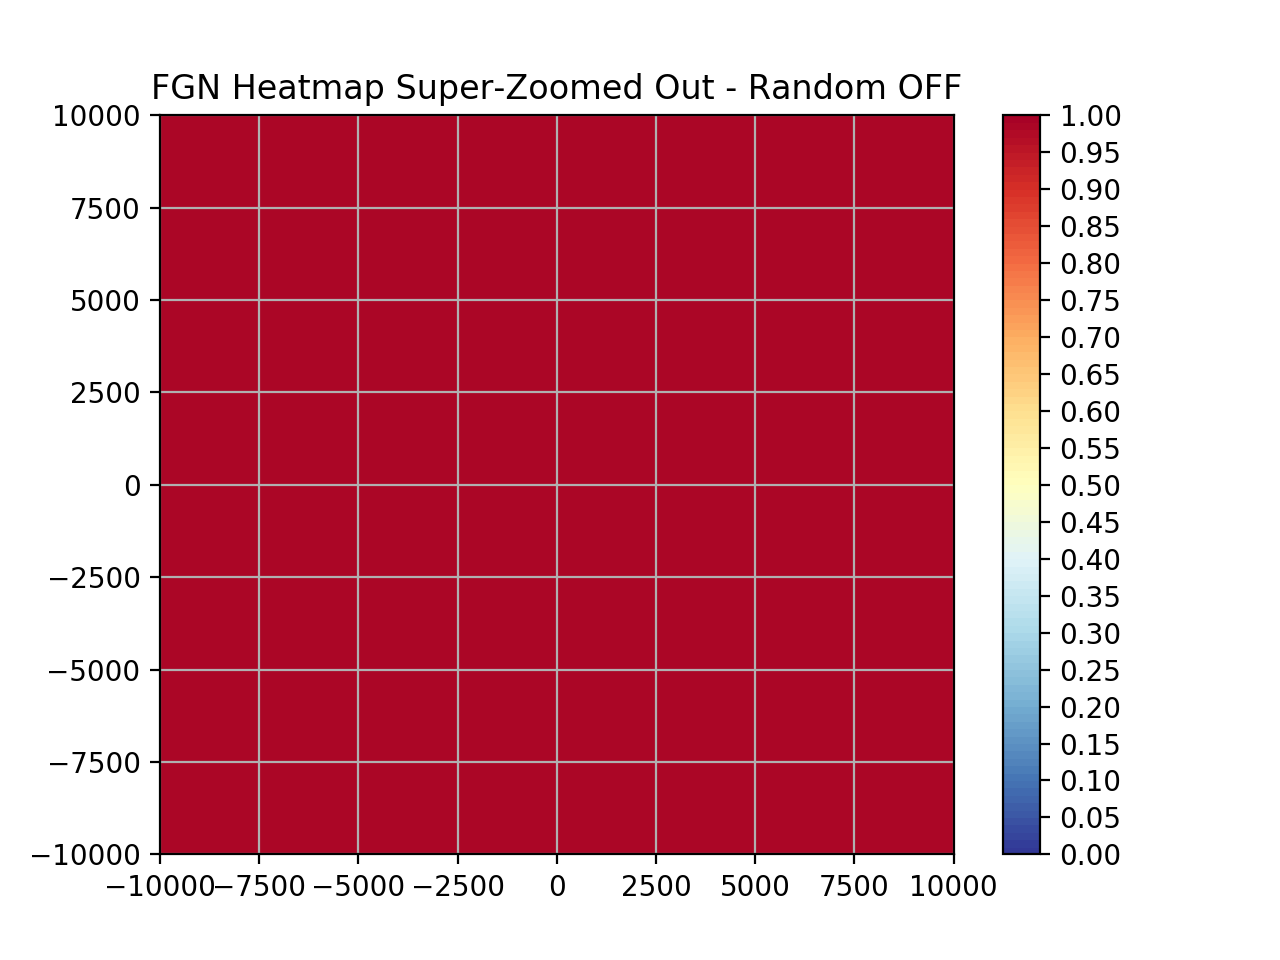

In [30]:
fgn_model.set_random_eval(False)
fgnh.plot_2D_heatmap(fgn_model, title="FGN Heatmap - Random OFF")
fgnh.plot_2D_heatmap(fgn_model, title="FGN Heatmap Zoomed Out - Random OFF", scale=100.0)
fgnh.plot_2D_heatmap(fgn_model, title="FGN Heatmap Super-Zoomed Out - Random OFF", scale=10000.0)

<IPython.core.display.Javascript object>


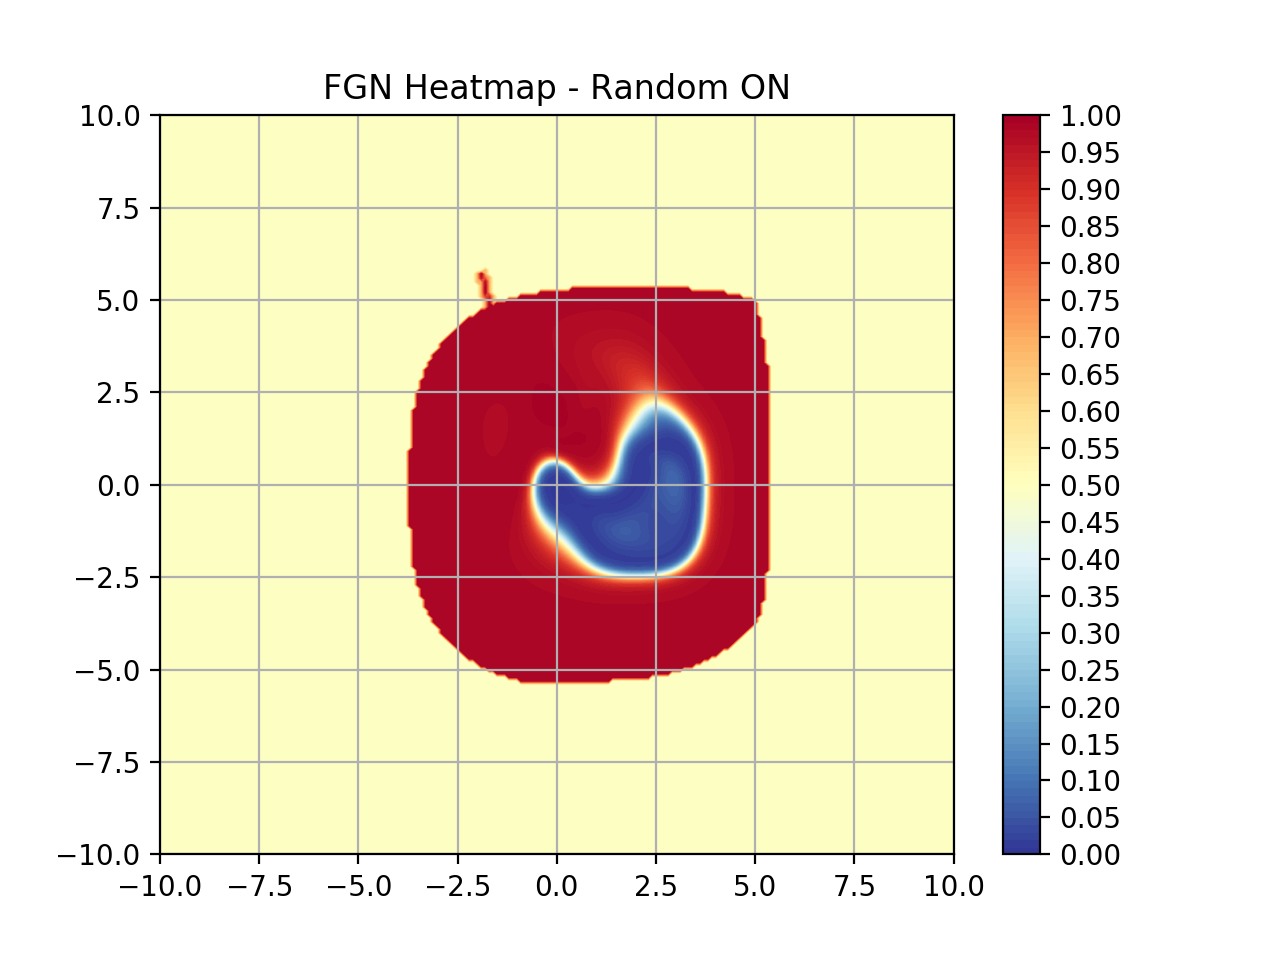

<IPython.core.display.Javascript object>


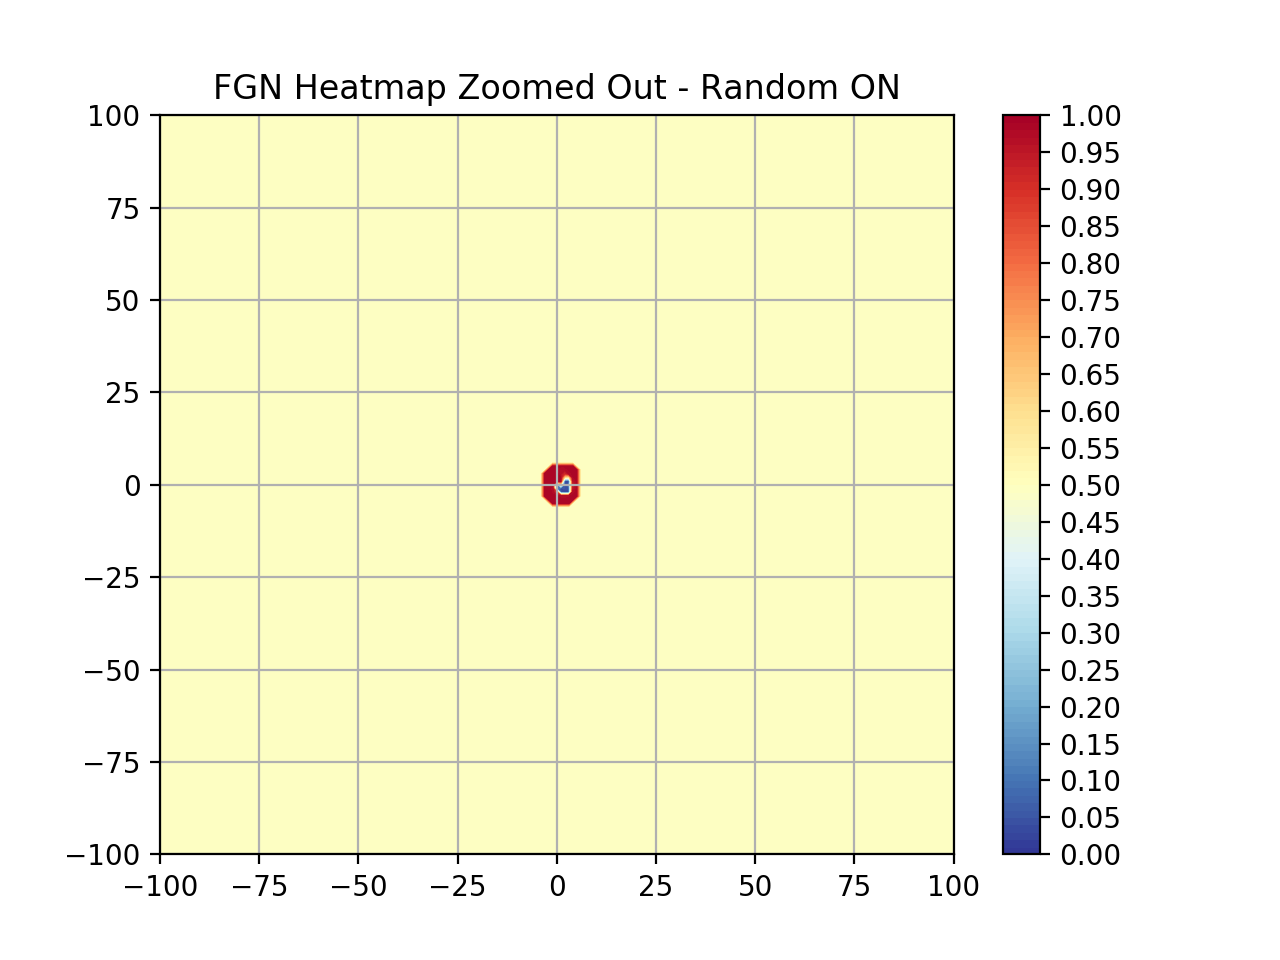

<IPython.core.display.Javascript object>


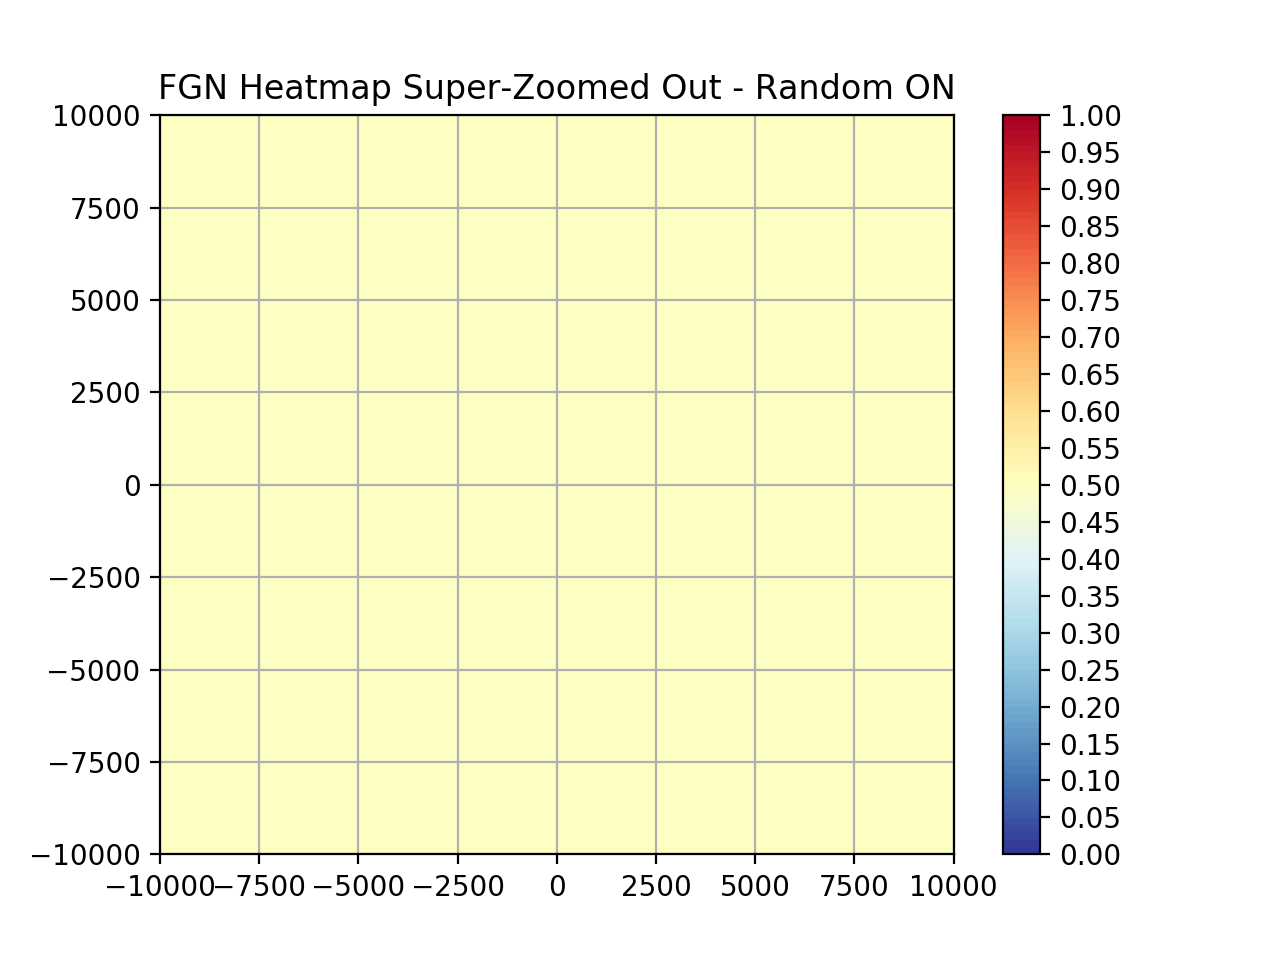

In [31]:
# compute predictions for heatmap with random eval
fgn_model.set_random_eval(True)
fgnh.plot_2D_heatmap(fgn_model, title="FGN Heatmap - Random ON")
fgnh.plot_2D_heatmap(fgn_model, title="FGN Heatmap Zoomed Out - Random ON", scale=100.0)
fgnh.plot_2D_heatmap(fgn_model, title="FGN Heatmap Super-Zoomed Out - Random ON", scale=10000.0)

<IPython.core.display.Javascript object>


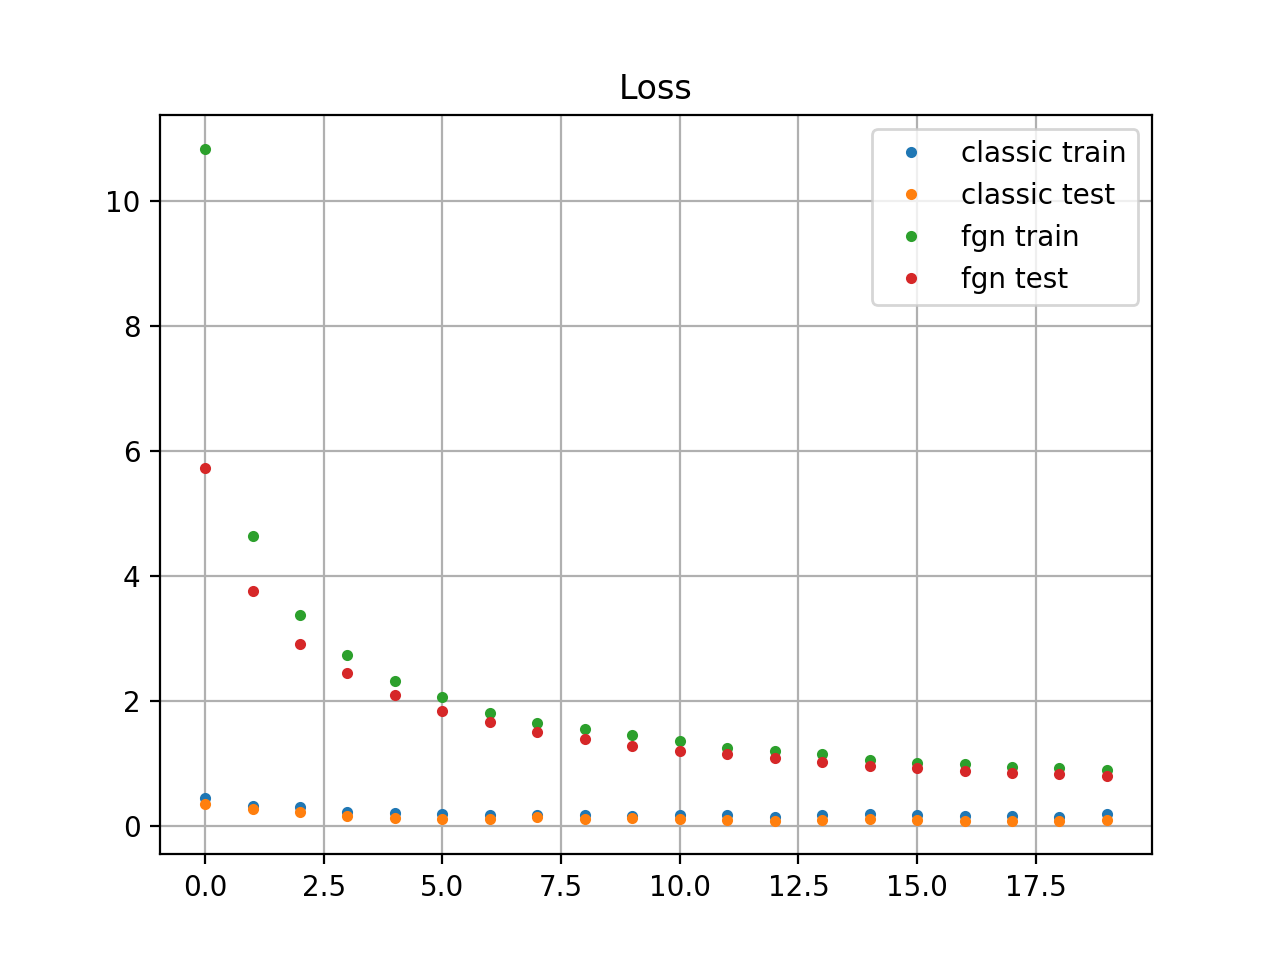

<IPython.core.display.Javascript object>


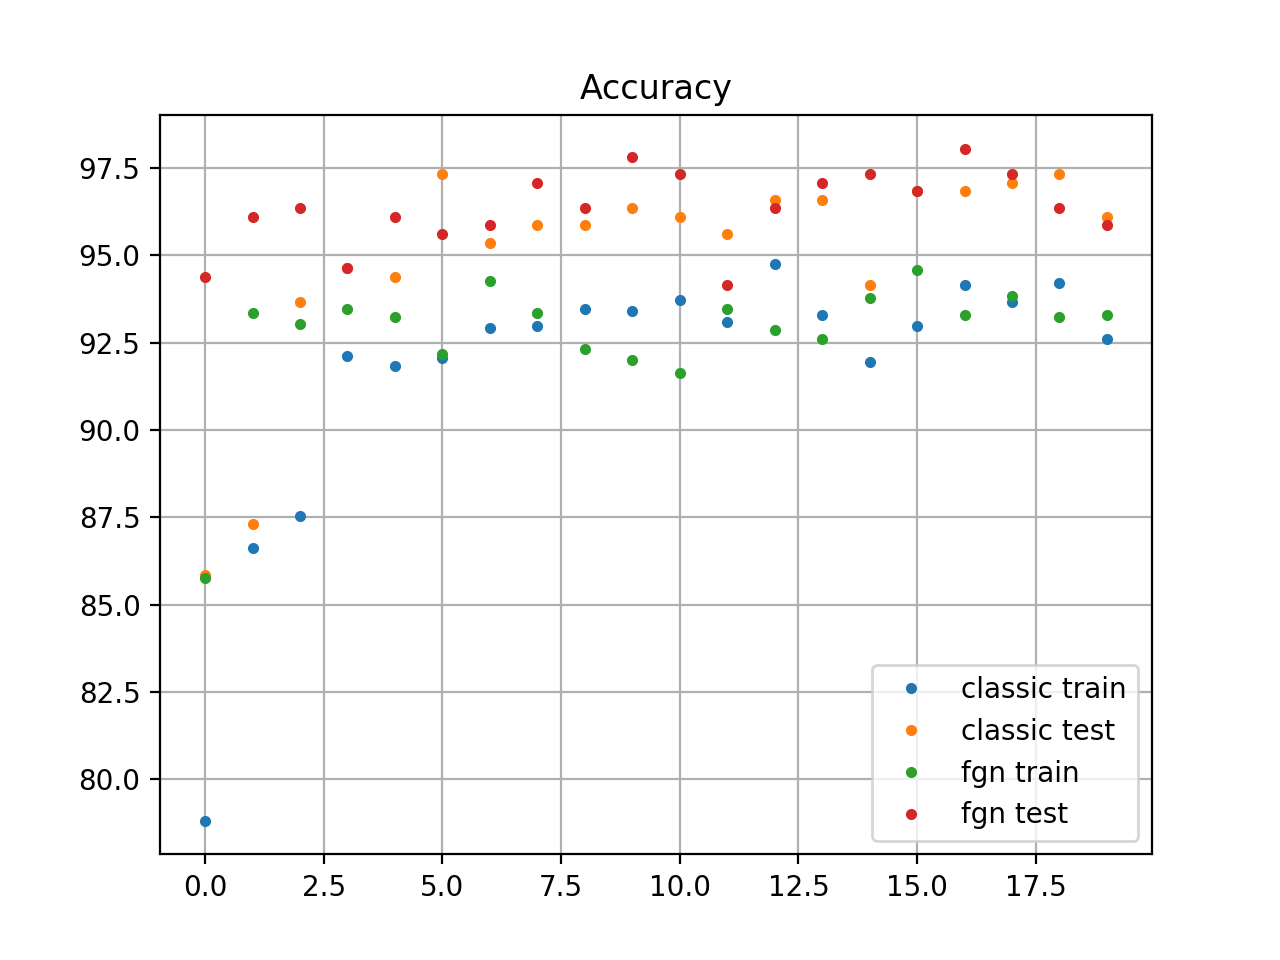

In [32]:
# acc and loss hist
plt.plot(classic_train_res['train_loss_hist'], marker='.', linestyle=' ', label='classic train')
plt.plot(classic_train_res['test_loss_hist'], marker='.', linestyle=' ', label='classic test')
plt.plot(fgn_train_res['train_loss_hist'], marker='.', linestyle=' ', label='fgn train')
plt.plot(fgn_train_res['test_loss_hist'], marker='.', linestyle=' ', label='fgn test')
plt.grid()
plt.legend()
plt.title('Loss')
plt.show()

plt.plot(classic_train_res['train_acc_hist'], marker='.', linestyle=' ', label='classic train')
plt.plot(classic_train_res['test_acc_hist'], marker='.', linestyle=' ', label='classic test')
plt.plot(fgn_train_res['train_acc_hist'], marker='.', linestyle=' ', label='fgn train')
plt.plot(fgn_train_res['test_acc_hist'], marker='.', linestyle=' ', label='fgn test')
plt.grid()
plt.legend()
plt.title('Accuracy')
plt.show()

In [33]:
### plot some FGN param movement during training

<IPython.core.display.Javascript object>


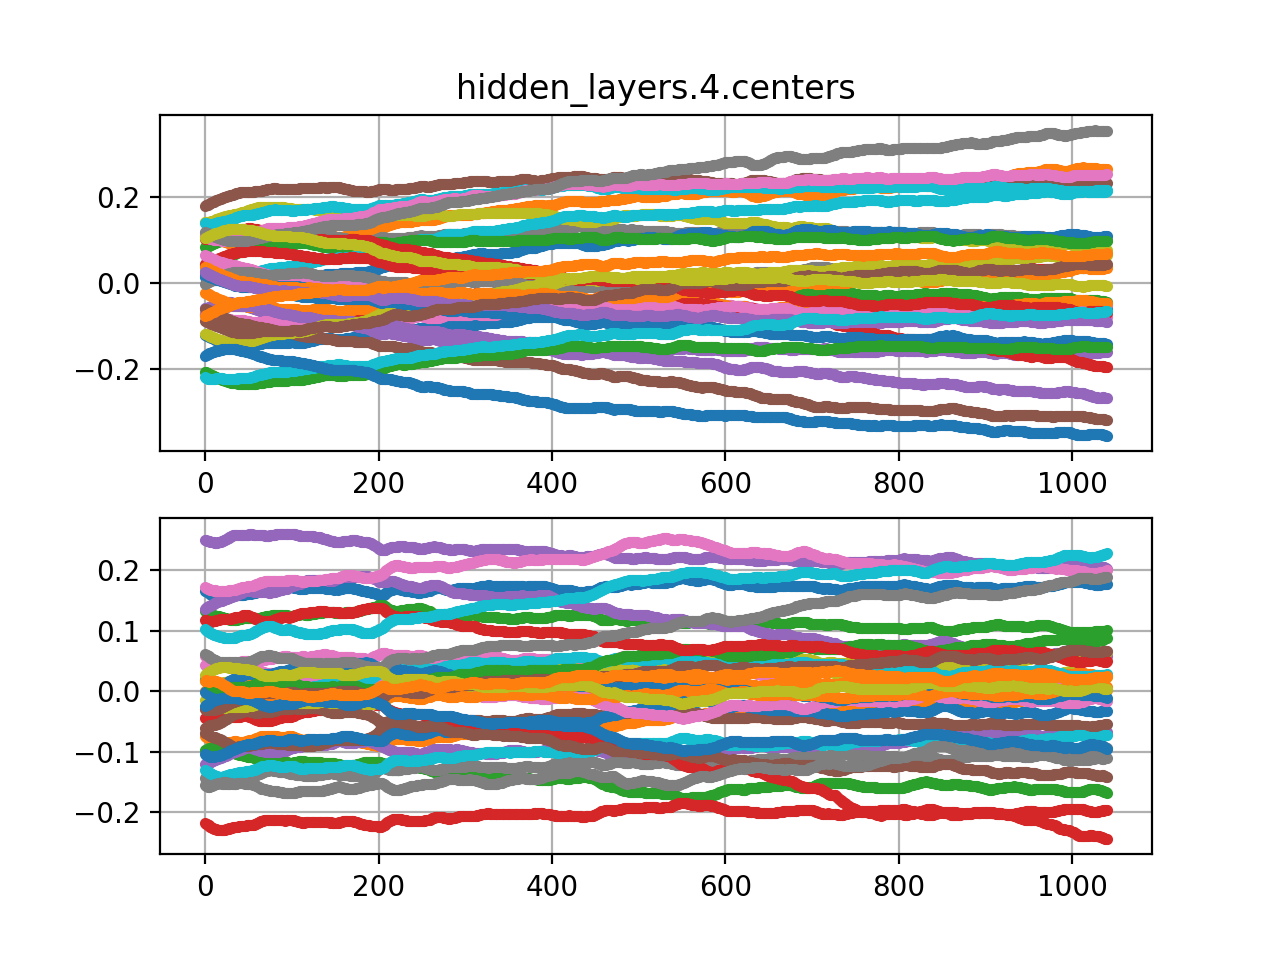

<IPython.core.display.Javascript object>


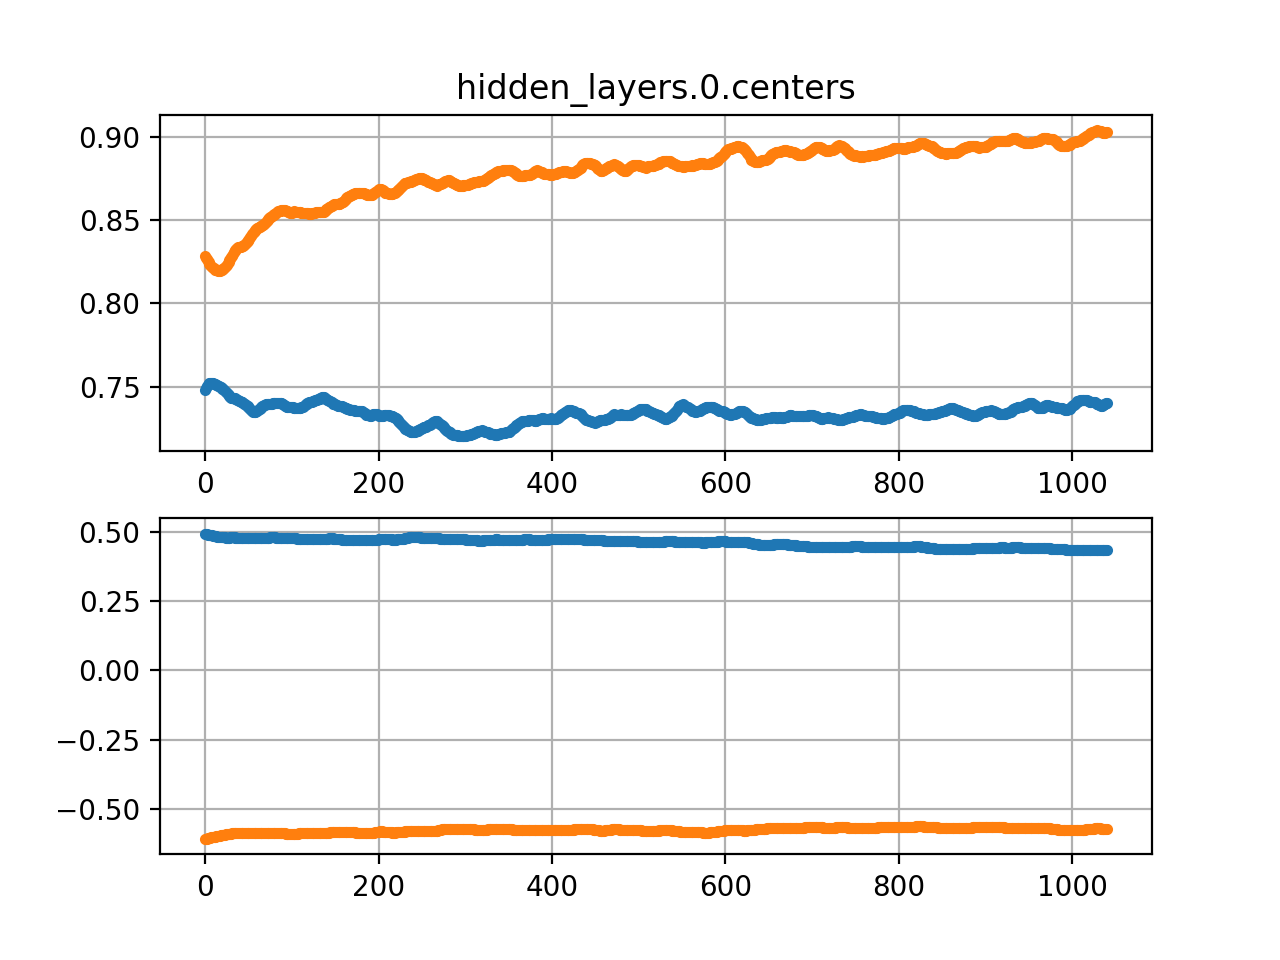

<IPython.core.display.Javascript object>


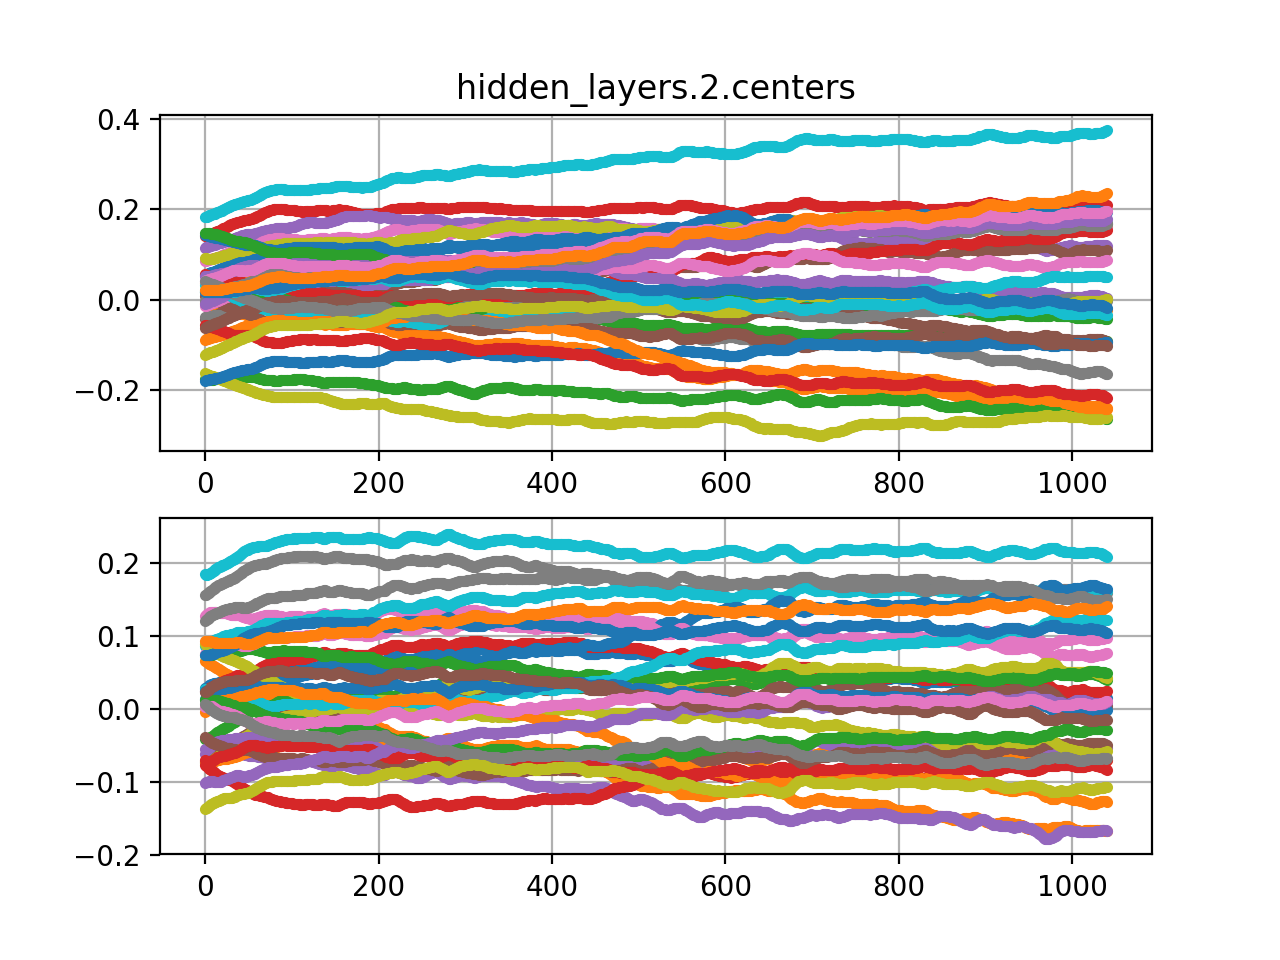

<IPython.core.display.Javascript object>


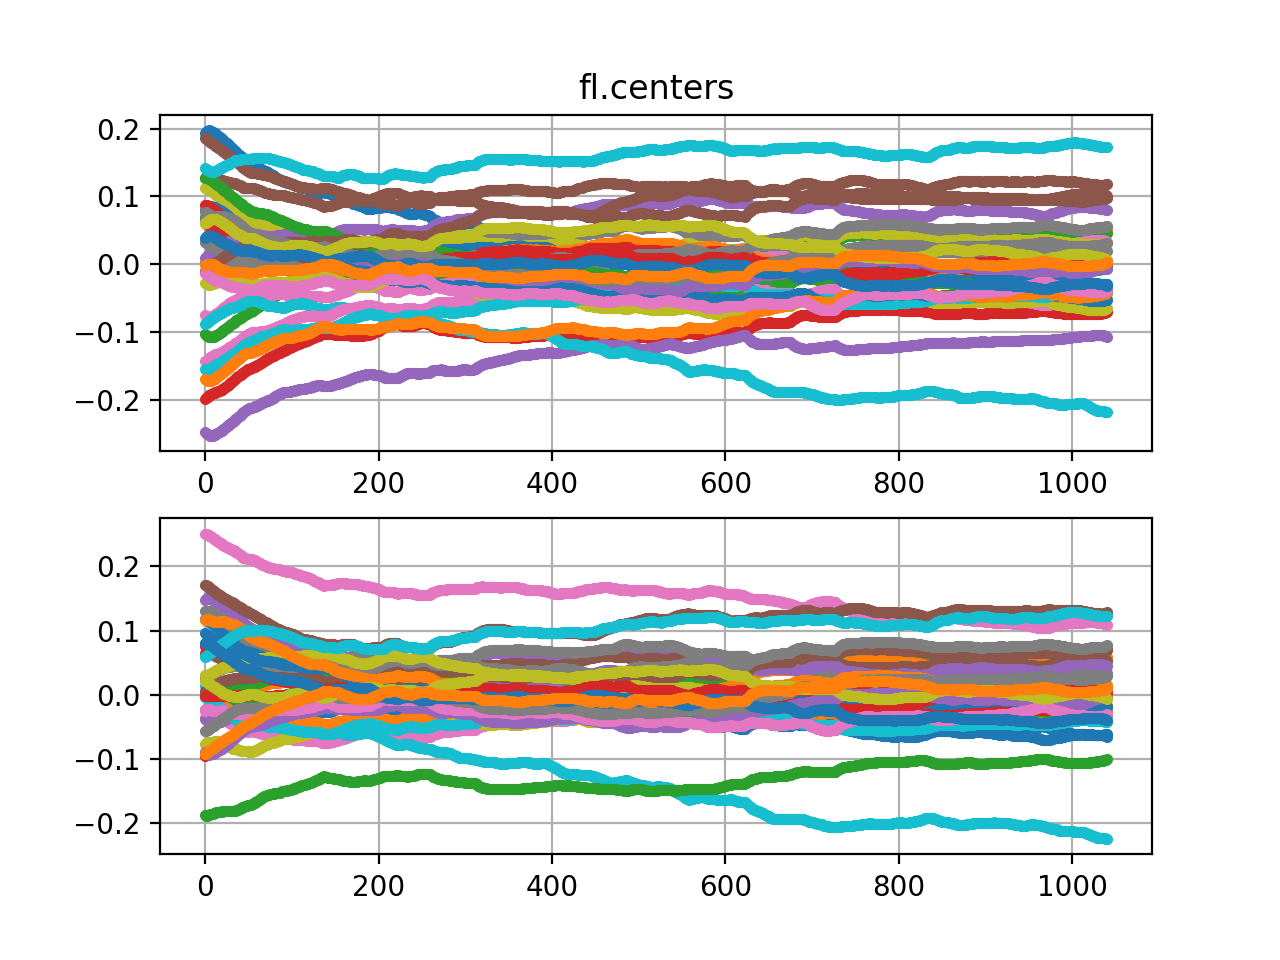

In [34]:
# plot centers history for only some hidden layer neuron
fgnl.plot_centers_histories(fgn_train_res['histories'])

<IPython.core.display.Javascript object>


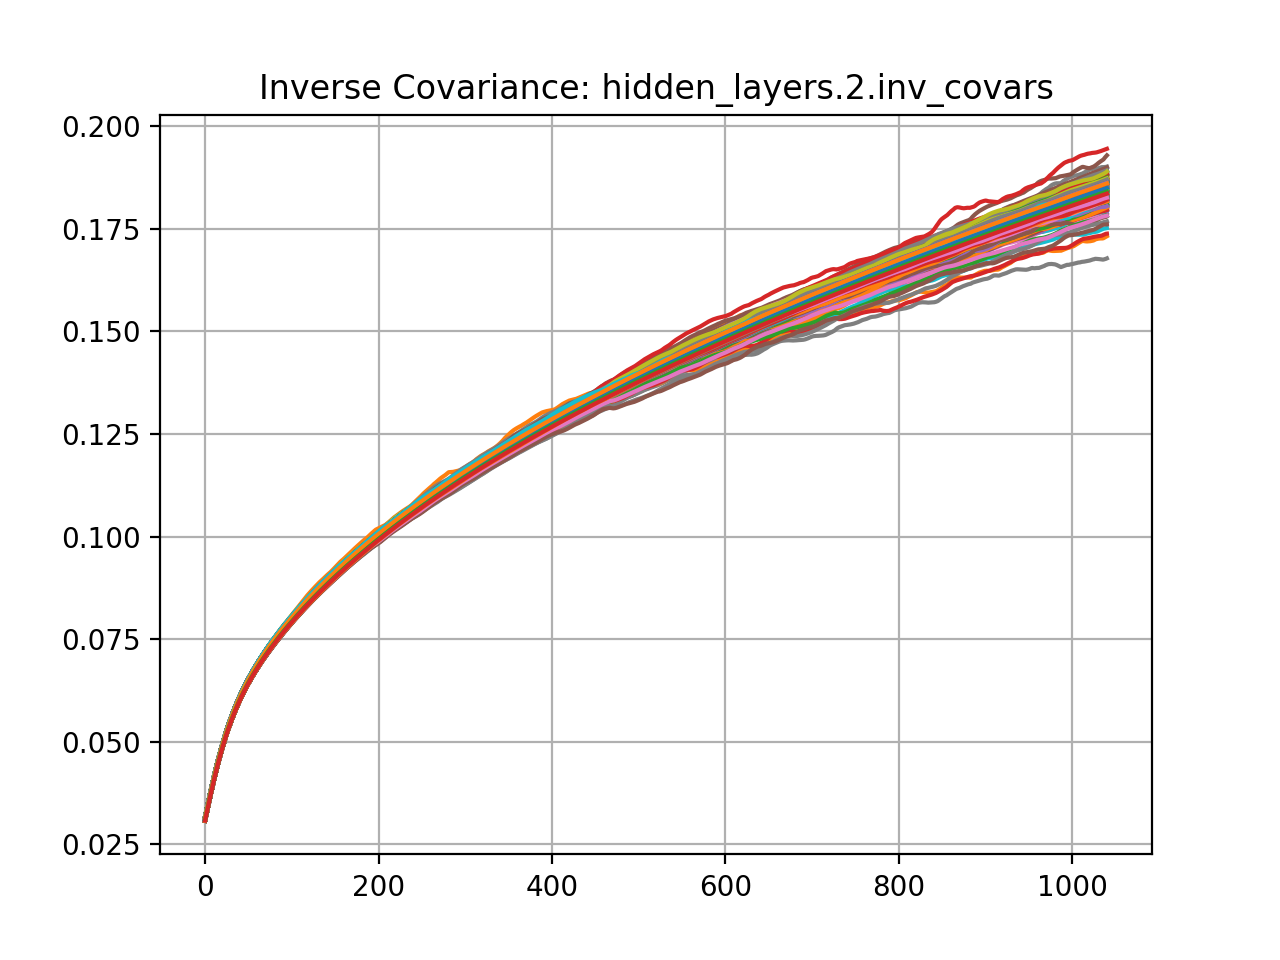

<IPython.core.display.Javascript object>


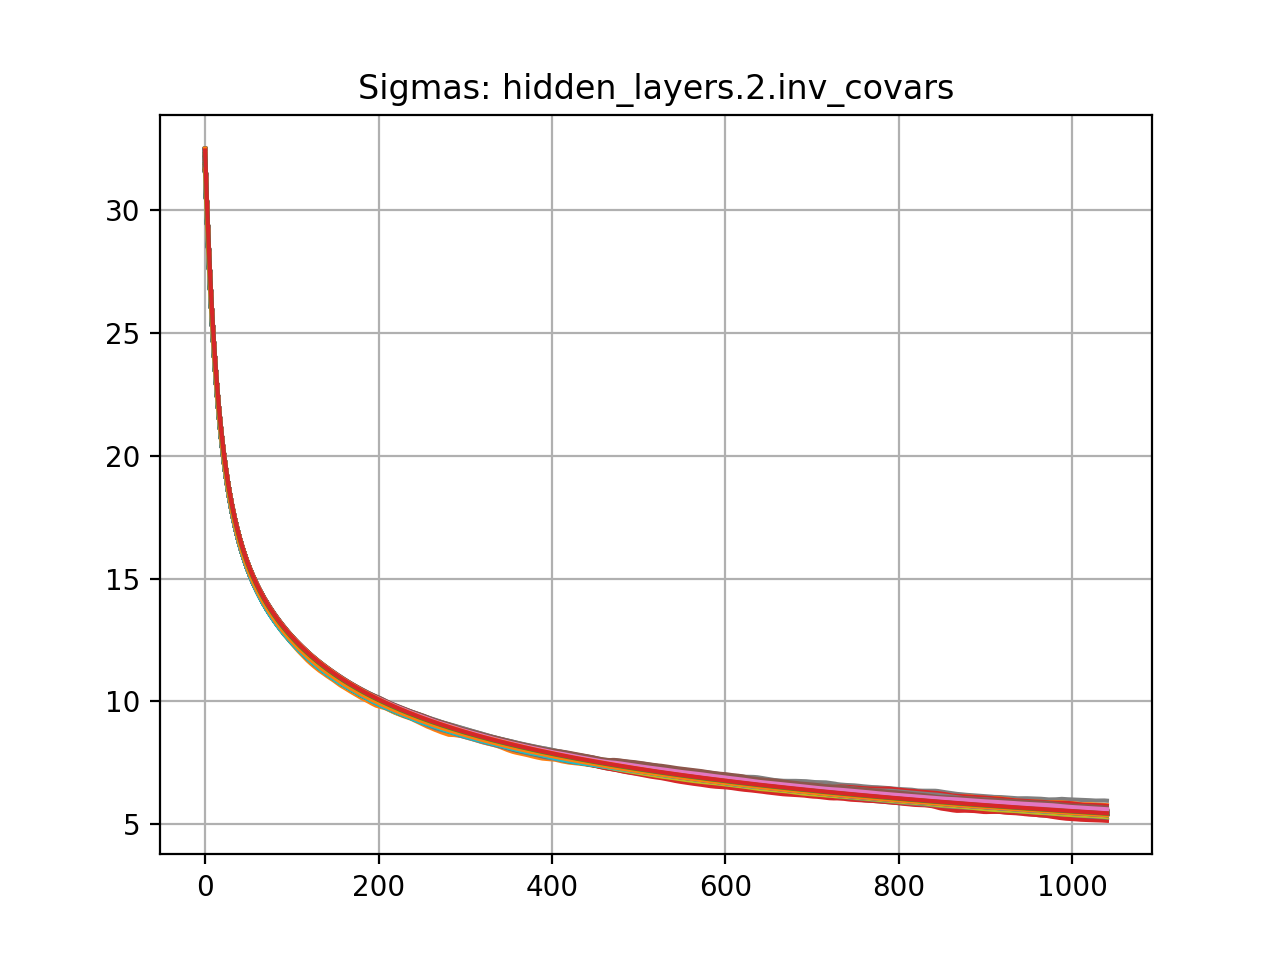

/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


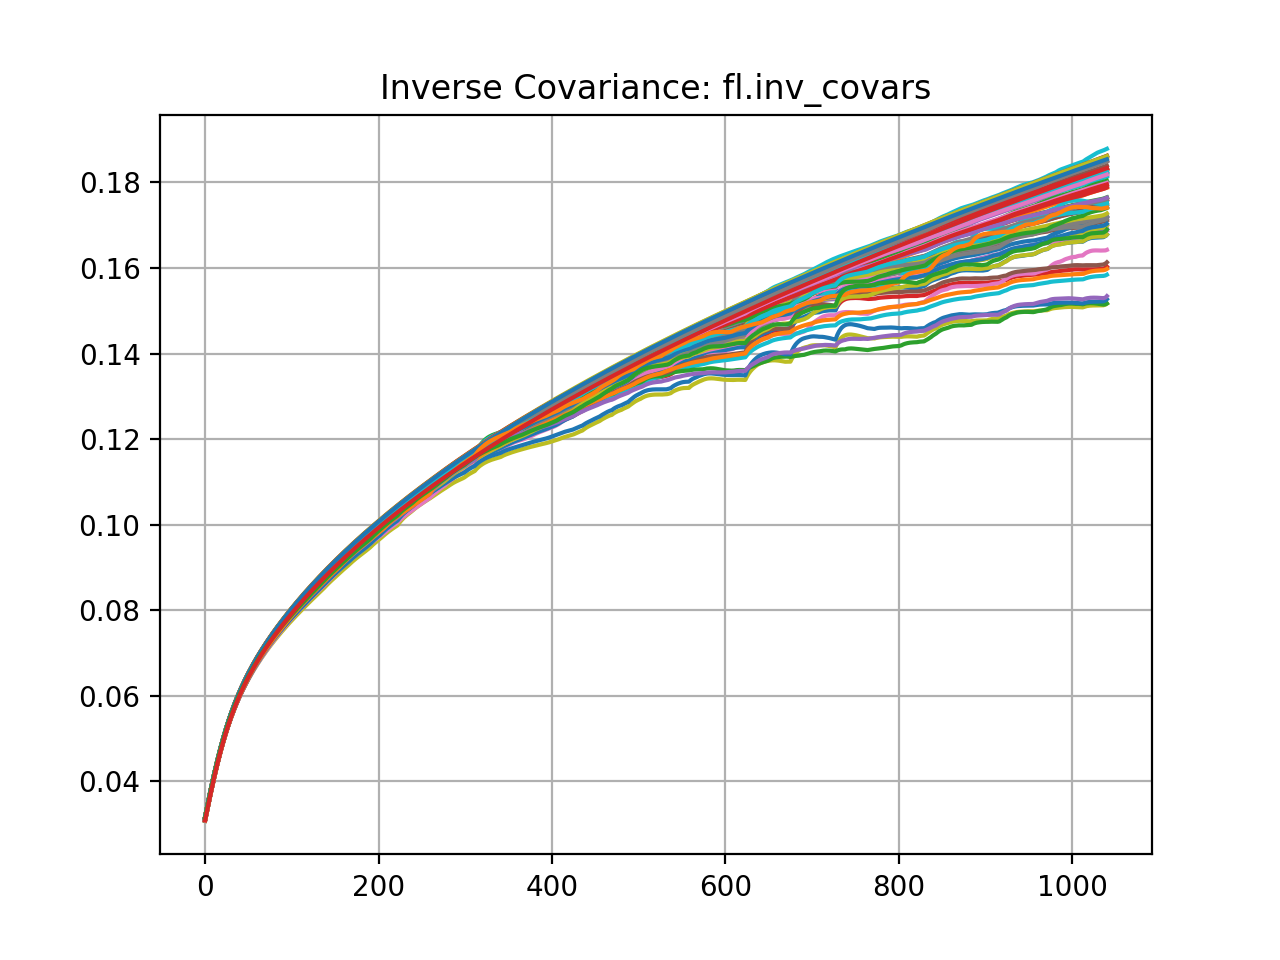

<IPython.core.display.Javascript object>


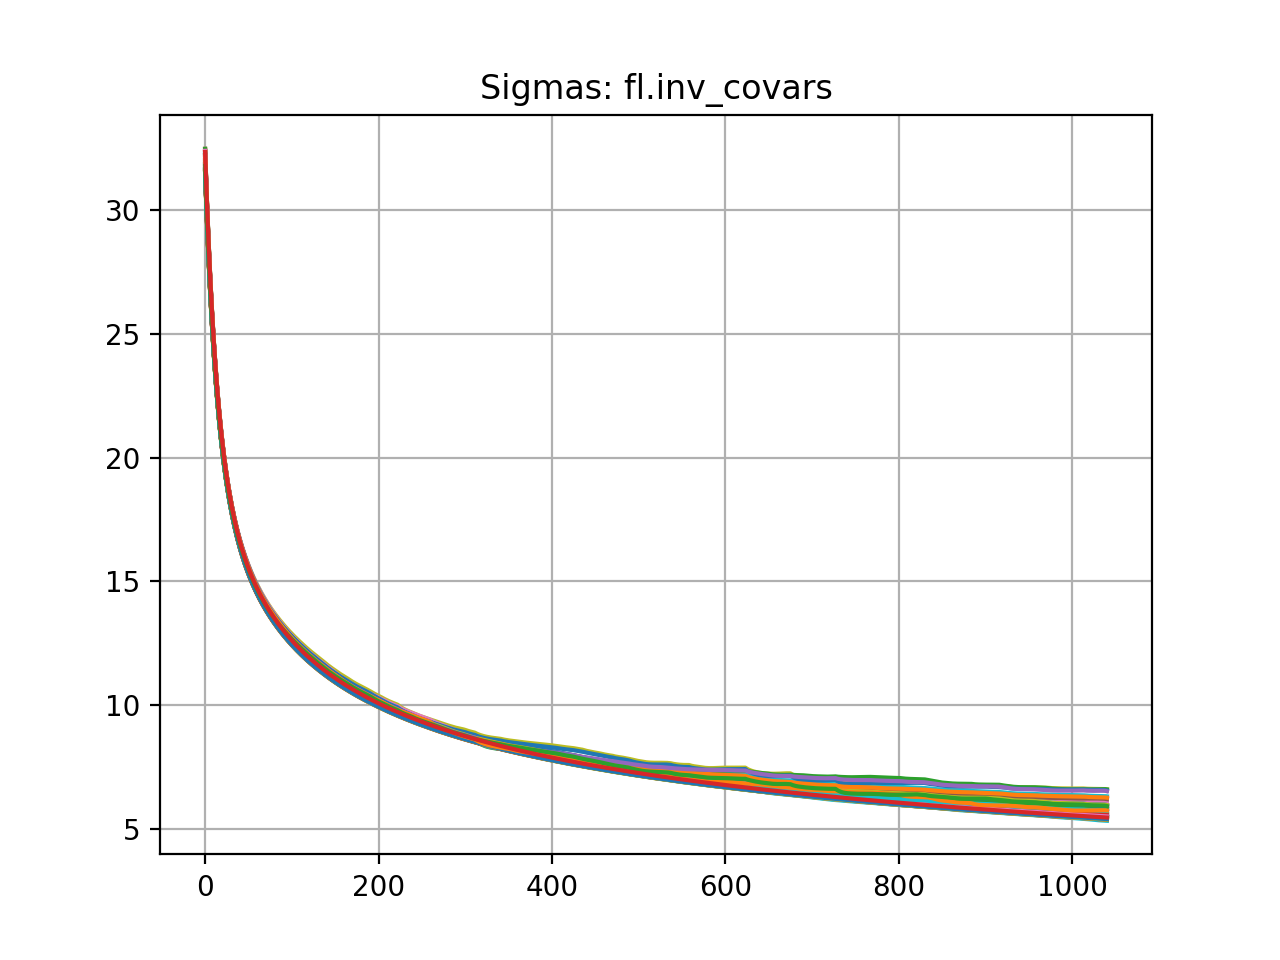

<IPython.core.display.Javascript object>


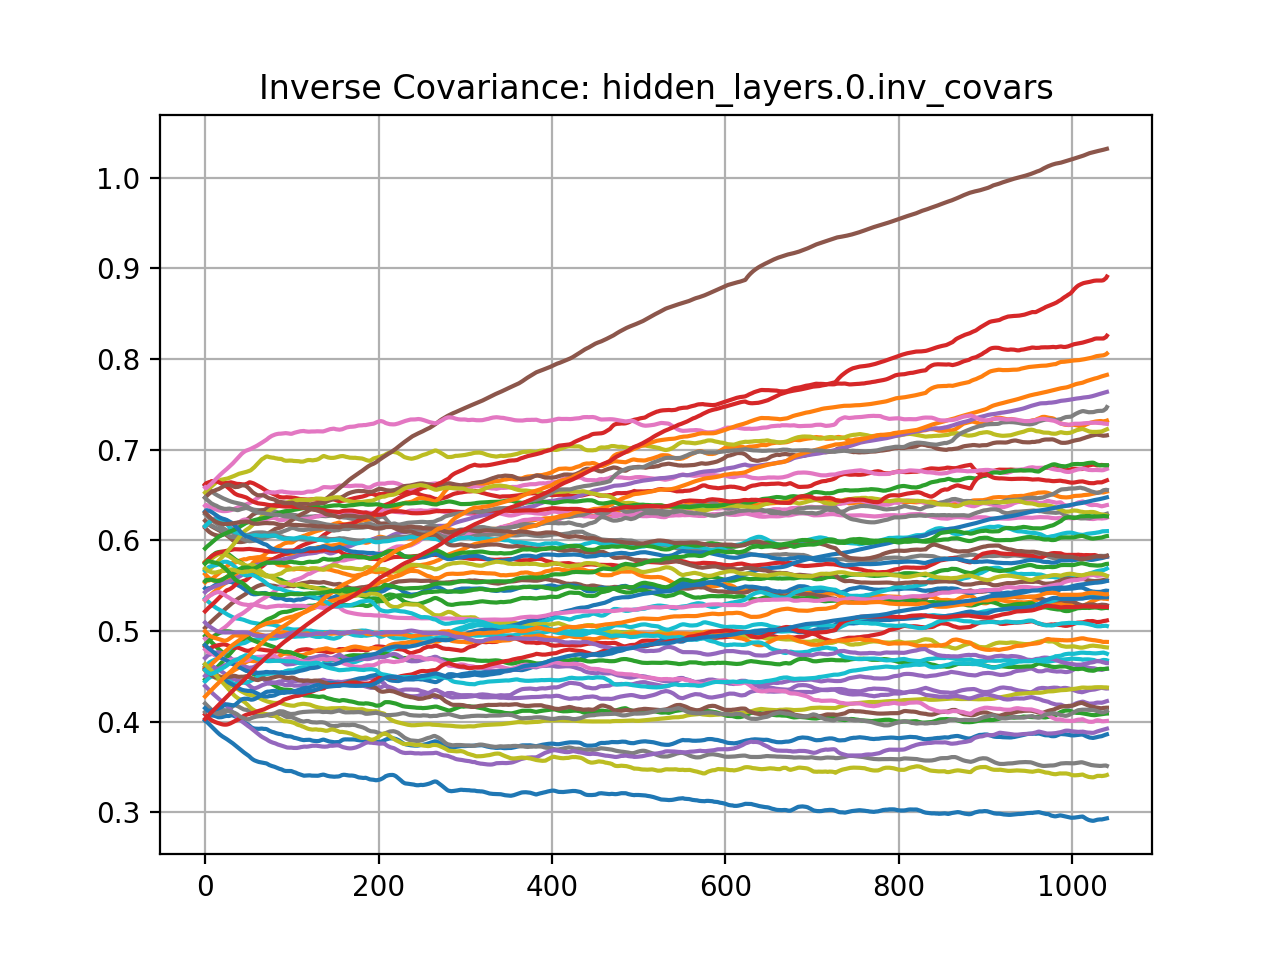

<IPython.core.display.Javascript object>


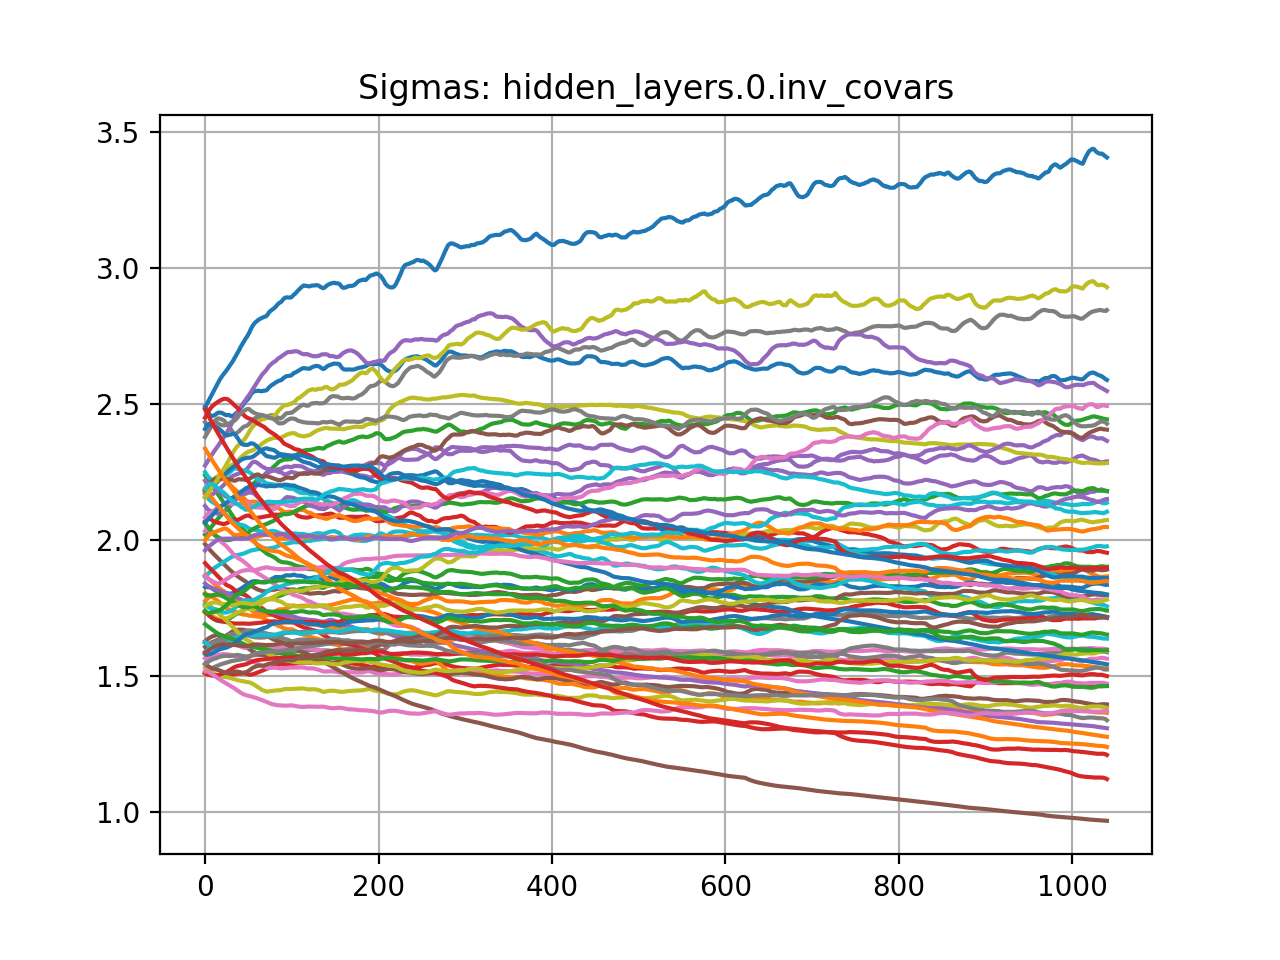

<IPython.core.display.Javascript object>


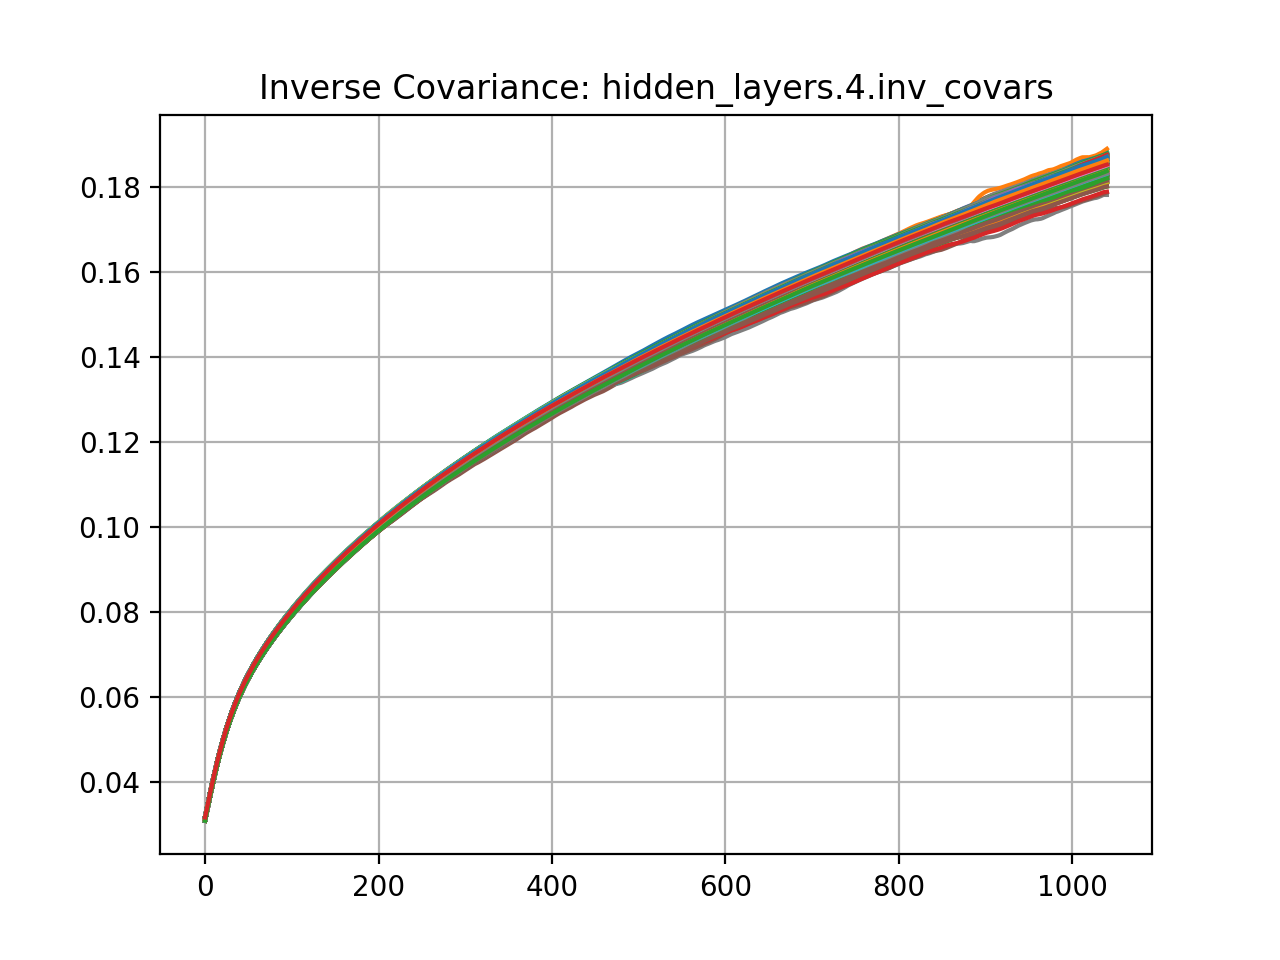

<IPython.core.display.Javascript object>


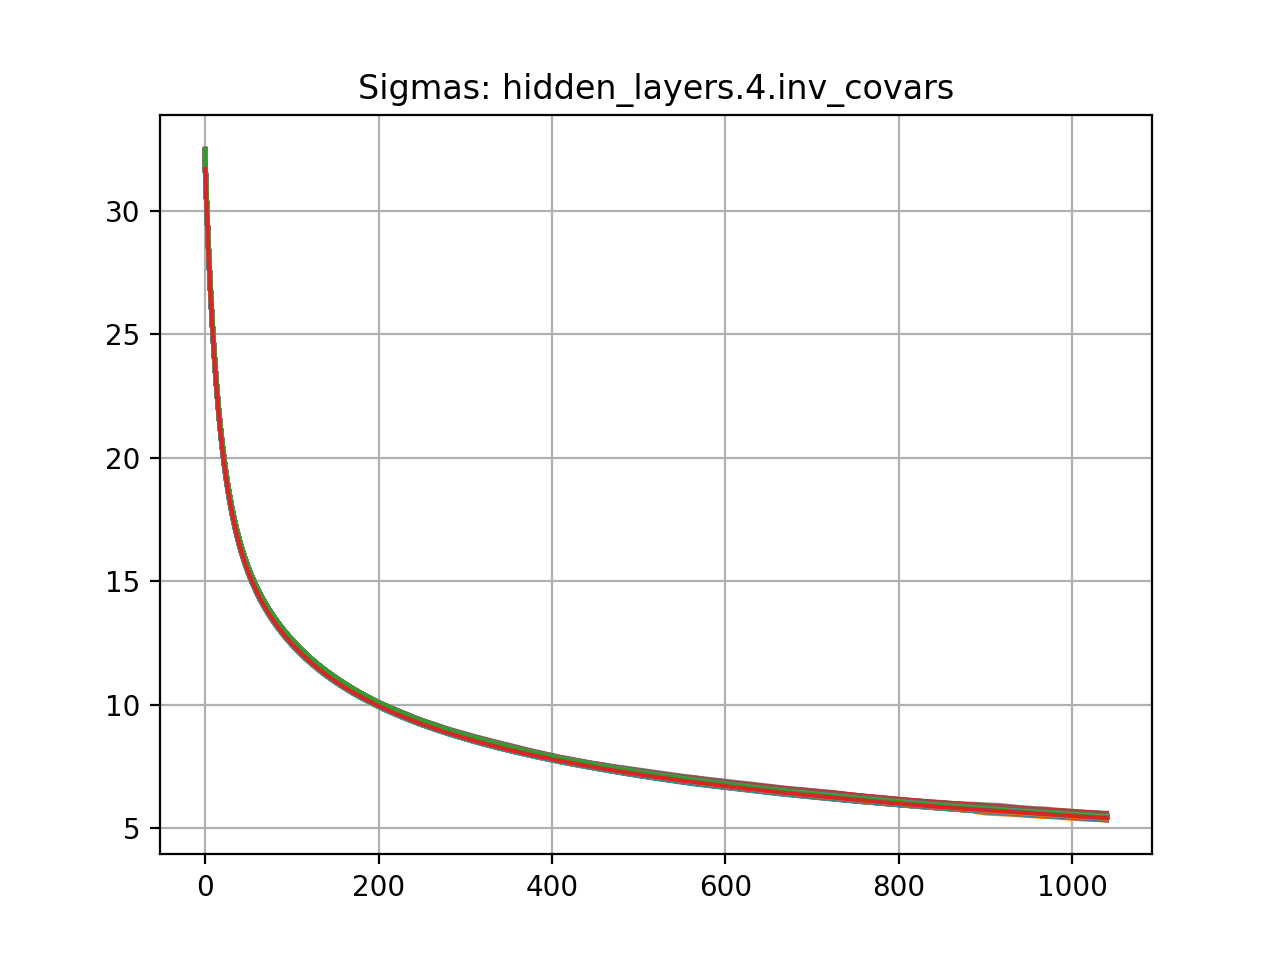

In [35]:
# check that inv covar has gone up, sigmas down, and trace down if covar_type=='full'
fgnl.plot_sigmas_histories(fgn_train_res['histories'])

In [36]:
# ### what about a converted net
# # Initialize the fgn network
# print("hidden layers:", hidden_l_nums)
# print("drop prob:", drop_p)
# converted_fgn_model = fgnl.Feedforward_FGN_net(in_feats=2, out_feats=2, hidden_l_nums=hidden_l_nums, drop_p=drop_p).to(device)

In [37]:
# fgnl.convert_classic_to_fgn(classic_model, converted_fgn_model)

In [38]:
# # make sure performance after isnt crap
# fgn_test_res_post = fgnh.test(converted_fgn_model, my_dataloader, 
#                      fgn_cross_ent_loss, verbose=True, 
#                      pred_func=fgnh.cross_ent_pred_accuracy)

In [39]:
# # compute predictions
# converted_fgn_model.eval()
# converted_fgn_heatmap_preds = converted_fgn_model(heatmap_inputs.to(device))
# converted_fgn_heatmap_preds = converted_fgn_heatmap_preds.cpu().detach().numpy()
# # apply softmax for probs
# converted_fgn_heatmap_preds_softmax = np.array([np.exp(x)/sum(np.exp(x)) for x in converted_fgn_heatmap_preds.astype('float128')])

In [40]:
# levels = np.arange(-0.0, 1.0+0.001, 10**(-2))
# ticks = levels[::5]

# plt.contourf(X1s, X2s, np.reshape(converted_fgn_heatmap_preds_softmax[:,0], np.shape(X1s) ),levels=levels, cmap= mpl.cm.RdYlBu_r)
# plt.colorbar(ticks=ticks)

# # # uncomment if you want to see the data and tighten the window
# # plt.scatter(samples_x_1, samples_y_1, alpha=0.1, c='gray')
# # plt.scatter(samples_x_2, samples_y_2, alpha=0.1, c='gray')
# # plt.axis([-1.5,2.5, -1, 1.5])


# plt.grid(True)
# plt.show()

In [41]:
# ### what are the sigmas
# for n,p in converted_fgn_model.named_parameters():
#     if 'sigmas' in n:
#         print(p)

In [42]:
# adjust sigmas

In [43]:
# def adjust_sigma_pred_func(fgn_model, dataloader, pred_func, verbose):
    
#     ###
#     # adjusts the sigmas of the given fgn model so that the pred accuracy over the dataset is max
#     ###
    
#     # best pred acc yet
#     fgn_test_res = fgnh.test(fgn_model, dataloader, 
#                              (lambda model, output, target:torch.tensor(0)), verbose=verbose, 
#                              pred_func=pred_func)
#     best_pred = fgn_test_res['test_accuracy']
#     # best sigma multiplier yet
#     best_sig_mult = 1.0
#     # lower bound for sigma mult
#     lower_bound = 0.0
#     # uper bound for sigma
#     upper_bound = float('Inf')
    
#     # max number of values to test
#     max_iter = 25
    
#     # first double sigmas until performance decreases
#     for ite in range(max_iter):
#         # new val to test
#         cur_sig_mult = 2.0*best_sig_mult
#         if verbose: print(ite, "testing", cur_sig_mult)
        
#         # apply multiplier
#         # given an fgn model, multiplies all the sigmas by a value
#         for p in fgn_model.modules():
#             if isinstance(p, fgnl.FGN_layer):
#                 p.sigmas = torch.nn.Parameter(p.sigmas*cur_sig_mult)
    
#         # test
#         fgn_test_res = fgnh.test(fgn_model, dataloader, 
#                              (lambda model, output, target:torch.tensor(0)), verbose=verbose, 
#                              pred_func=pred_func)
#         cur_pred = fgn_test_res['test_accuracy']
        
#         # reset sigmas 
#         for p in fgn_model.modules():
#             if isinstance(p, fgnl.FGN_layer):
#                 p.sigmas = torch.nn.Parameter(p.sigmas/cur_sig_mult)
                
#         if cur_pred > best_pred:
#             if verbose: print("new best during doubling")
#             # new best
#             best_pred = cur_pred
#             best_sig_mult = cur_sig_mult
#             # increase lower bound
#             lower_bound = cur_sig_mult
#         else:
#             # new upper bound
#             upper_bound = cur_sig_mult
#             # and exit loop
#             break
            
            
#     # next half sigmas until performance decreases
#     for ite in range(max_iter):
#         # new val to test
#         cur_sig_mult = 0.5*best_sig_mult
#         if verbose: print(ite, "testing", cur_sig_mult)
        
#         # apply multiplier
#         # given an fgn model, multiplies all the sigmas by a value
#         for p in fgn_model.modules():
#             if isinstance(p, fgnl.FGN_layer):
#                 p.sigmas = torch.nn.Parameter(p.sigmas*cur_sig_mult)
    
#         # test
#         fgn_test_res = fgnh.test(fgn_model, dataloader, 
#                              (lambda model, output, target:torch.tensor(0)), verbose=verbose, 
#                              pred_func=pred_func)
#         cur_pred = fgn_test_res['test_accuracy']
        
#         # reset sigmas 
#         for p in fgn_model.modules():
#             if isinstance(p, fgnl.FGN_layer):
#                 p.sigmas = torch.nn.Parameter(p.sigmas/cur_sig_mult)
                
#         if cur_pred >= (1.0-1e-3)*best_pred:
#             if verbose: print("new best during halfing")
#             # new best
#             best_pred = cur_pred
#             best_sig_mult = cur_sig_mult
#             # new upper bound
#             upper_bound = cur_sig_mult
#         else:
#             # increase lower bound
#             lower_bound = cur_sig_mult
#             # and exit loop
#             break
    
#     # now that we have a real bounds, search by dichotomie
#     for ite in range(max_iter):

#         # new val to test
#         cur_sig_mult = 0.5*(upper_bound+lower_bound)
#         if verbose: print(ite, "testing", cur_sig_mult)
        
#         # apply multiplier
#         # given an fgn model, multiplies all the sigmas by a value
#         for p in fgn_model.modules():
#             if isinstance(p, fgnl.FGN_layer):
#                 p.sigmas = torch.nn.Parameter(p.sigmas*cur_sig_mult)
    
#         # test
#         fgn_test_res = fgnh.test(fgn_model, dataloader, 
#                              (lambda model, output, target:torch.tensor(0)), verbose=verbose, 
#                              pred_func=pred_func)
#         cur_pred = fgn_test_res['test_accuracy']
        
#         # reset sigmas 
#         for p in fgn_model.modules():
#             if isinstance(p, fgnl.FGN_layer):
#                 p.sigmas = torch.nn.Parameter(p.sigmas/cur_sig_mult)
                
#         if cur_pred >= (1.0-1e-3)*best_pred:
#             if verbose: print("new best during dicho")
#             # new low bound
#             if cur_sig_mult > best_sig_mult:
#                 lower_bound = cur_sig_mult
#             # new upper bound
#             else:
#                 upper_bound = cur_sig_mult
#             # new best
#             best_pred = cur_pred
#             best_sig_mult = cur_sig_mult
                
#         else:
#             # new low bound
#             if cur_sig_mult < best_sig_mult:
#                 lower_bound = cur_sig_mult
#             # new upper bound
#             else:
#                 upper_bound = cur_sig_mult
            
#     # apply best mult
#     if verbose: print("best multiplier:", best_sig_mult)
#     for p in fgn_model.modules():
#         if isinstance(p, fgnl.FGN_layer):
#             p.sigmas = torch.nn.Parameter(p.sigmas*best_sig_mult)
            
#     return None

In [44]:
# adjust_sigma_pred_func(converted_fgn_model, my_dataloader, fgnh.cross_ent_pred_accuracy, verbose=True)

In [45]:
# # make sure performance after isnt crap
# fgn_test_res_post = fgnh.test(converted_fgn_model, my_dataloader, 
#                      fgn_cross_ent_loss, verbose=True, 
#                      pred_func=fgnh.cross_ent_pred_accuracy)

In [46]:
## post adjusting heatmap

In [47]:
# # compute predictions
# converted_fgn_model.eval()
# converted_fgn_heatmap_preds = converted_fgn_model(heatmap_inputs.to(device))
# converted_fgn_heatmap_preds = converted_fgn_heatmap_preds.cpu().detach().numpy()
# # apply softmax for probs
# converted_fgn_heatmap_preds_softmax = np.array([np.exp(x)/sum(np.exp(x)) for x in converted_fgn_heatmap_preds.astype('float128')])

In [48]:
# levels = np.arange(-0.0, 1.0+0.001, 10**(-2))
# ticks = levels[::5]

# plt.contourf(X1s, X2s, np.reshape(converted_fgn_heatmap_preds_softmax[:,0], np.shape(X1s) ),levels=levels, cmap= mpl.cm.RdYlBu_r)
# plt.colorbar(ticks=ticks)

# # # uncomment if you want to see the data and tighten the window
# # plt.scatter(samples_x_1, samples_y_1, alpha=0.1, c='gray')
# # plt.scatter(samples_x_2, samples_y_2, alpha=0.1, c='gray')
# # plt.axis([-1.5,2.5, -1, 1.5])

# plt.grid(True)
# plt.show()

In [49]:
# ### what are the sigmas
# for n,p in converted_fgn_model.named_parameters():
#     if 'sigmas' in n:
#         print(p)

In [50]:
# next idea: use grad descent to adjust sigmas and centers 

In [51]:
# for p in converted_fgn_model.named_parameters():
#     if 'weights' in p[0]:
#         print(p[1])

In [52]:
# # converted_fgn_sigmas_optimizer = optim.RMSprop([p[1] for p in converted_fgn_model.named_parameters()
# #                                       if p[1].requires_grad and ('censdfsdfsdfters' in p[0] or 'sigmas' in p[0])], 
# #                                      momentum=0.5)

# # converted_fgn_sigmas_optimizer = optim.RMSprop(filter(lambda p: (p[1].requires_grad),
# #                                                                  converted_fgn_model.named_parameters()),momentum=0.5)

# converted_fgn_sigmas_optimizer = optim.RMSprop([p[1] for p in converted_fgn_model.named_parameters()
#                                       if (p[1].requires_grad and 
#                                           (('weight' in p[0] and not 'weights' in p[0]) or 'bias' in p[0] 
#                                            or 'sigmas' in p[0] 
#                                            or 'centers'in p[0]))], 
#                                      momentum=0.5)

In [53]:
# converted_fgn_train_res = fgnh.train(converted_fgn_model, my_dataloader, 
#                              fgn_cross_ent_loss, converted_fgn_sigmas_optimizer, epochs, save_hist=2, verbose=True, 
#                              pred_func=fgnh.cross_ent_pred_accuracy, test_loader=my_test_dataloader)

In [54]:
# # compute predictions
# converted_fgn_model.eval()
# converted_fgn_heatmap_preds = converted_fgn_model(heatmap_inputs.to(device))
# converted_fgn_heatmap_preds = converted_fgn_heatmap_preds.cpu().detach().numpy()
# # apply softmax for probs
# converted_fgn_heatmap_preds = np.array([np.exp(x)/sum(np.exp(x)) for x in converted_fgn_heatmap_preds.astype('float128')])

In [55]:
# levels = np.arange(-0.0, 1.0+0.001, 10**(-2))
# ticks = levels[::5]

# plt.contourf(X1s, X2s, np.reshape(converted_fgn_heatmap_preds[:,0], np.shape(X1s) ),levels=levels, cmap= mpl.cm.RdYlBu_r)
# plt.colorbar(ticks=ticks)

# # # uncomment if you want to see the data and tighten the window
# # plt.scatter(samples_x_1, samples_y_1, alpha=0.1, c='gray')
# # plt.scatter(samples_x_2, samples_y_2, alpha=0.1, c='gray')
# # plt.axis([-1.5,2.5, -1, 1.5])

# plt.grid(True)
# plt.show()

In [56]:
# ### what are the sigmas
# for n,p in converted_fgn_model.named_parameters():
#     if 'sigmas' in n:
#         print(p)

In [57]:
# # make sure performance after isnt crap
# fgn_test_res_post = fgnh.test(converted_fgn_model, my_dataloader, 
#                      fgn_cross_ent_loss, verbose=True, 
#                      pred_func=fgnh.cross_ent_pred_accuracy)

In [58]:
# for p in converted_fgn_model.named_parameters():
#     if 'weights' in p[0]:
#         print(p[1])